# Get the final dataset

**Goal:** this notebook computes the final dataset used in the next part from the raw impact. It combines a lot of knowledge from the [`/analysis/description/first_study`](https://github.com/ElsaB/impact-annotator/tree/master/analysis/description/first_study) folder to filter, clean, curate and annotate the raw dataset. The final annotation kept is the one from VEP. All the operations made are stored in the [`compute_final_dataset.R`](https://github.com/ElsaB/impact-annotator/blob/master/data/utils/compute_final_dataset.R) file, and can be applied on the raw dataset by using the `get_final_dataset()` function.

This notebook is divided in 3 parts:
* **1. Get click_annotvcf annotations**
* **2. Adapt the `get_cleaned_impact()` function**
* **3. Process raw features**

In [1]:
source("../../../src/utils/custom_tools.R")
setup_environment("../../../src/utils")

Warning message:
“package ‘dplyr’ was built under R version 3.5.1”

In [2]:
impact <- read.table("../../../data/all_IMPACT_mutations_180508.txt", sep = "\t", stringsAsFactors = FALSE, header = TRUE)

In [3]:
nrow(impact)

[1] 588547

## Get click_annotvcf annotations

Get the features from `click_annotvcf_IMPACT_mutations_180508.txt` (impact annotated by the click_annotvcf pipeline).

### Get the raw data

In [4]:
impact_annotated <- read.table("../../../data/annotate_with_click_annotvcf/click_annotvcf_IMPACT_mutations_180508.txt",
                               sep = "\t", stringsAsFactors = FALSE, header = TRUE, comment = "#")

In [5]:
ncol(impact_annotated)
nrow(impact_annotated)
head(impact_annotated)

[1] 156

[1] 406833

ID_VARIANT    TARGET_NAME REFERENCE_NAME CHR START   END     REF ALT
1 1_2487766_T_C NA          NA             1   2487766 2487766 T   C  
2 1_2487954_G_A NA          NA             1   2487954 2487954 G   A  
3 1_2487984_C_A NA          NA             1   2487984 2487984 C   A  
4 1_2487998_C_G NA          NA             1   2487998 2487998 C   G  
5 1_2487998_C_T NA          NA             1   2487998 2487998 C   T  
6 1_2488032_A_G NA          NA             1   2488032 2488032 A   G  
  CONTEXT_5 CHANGE CONTEXT_3 QUAL CALLED_BY PASSED_BY NUMBER_OF_CALLERS
1 TGGAA     C      GGTGC     NA   NA        NA        0                
2 GCTCG     A      GTTCT     NA   NA        NA        0                
3 CGAGG     A      GGATT     NA   NA        NA        0                
4 TTTCT     G      TTTCT     NA   NA        NA        0                
5 TTTCT     T      TTTCT     NA   NA        NA        0                
6 CAGCA     G      TGGCG     NA   NA        NA        0                
  FLAGS_ALL TARGET_VAF_MEAN TARGET_VAF_STD REFERENCE_VAF_MEAN REFERENCE_VAF_STD
1 PASS      NA              NA             NA                 NA               
2 PASS      NA              NA             NA                 NA               
3 PASS      NA              NA             NA                 NA               
4 PASS      NA              NA             NA                 NA               
5 PASS      NA              NA             NA                 NA               
6 PASS      NA              NA             NA                 NA               
  mutect_TARGET_VAF mutect_TARGET_DEPTH mutect_REFERENCE_VAF
1 NA                NA                  NA                  
2 NA                NA                  NA                  
3 NA                NA                  NA                  
4 NA                NA                  NA                  
5 NA                NA                  NA                  
6 NA                NA                  NA                  
  mutect_REFERENCE_DEPTH mutect_DIRPROP mutect_READS_FORWARD
1 NA                     NA             NA                  
2 NA                     NA             NA                  
3 NA                     NA             NA                  
4 NA                     NA             NA                  
5 NA                     NA             NA                  
6 NA                     NA             NA                  
  mutect_READS_REVERSE strelka_TARGET_VAF strelka_TARGET_DEPTH
1 NA                   NA                 NA                  
2 NA                   NA                 NA                  
3 NA                   NA                 NA                  
4 NA                   NA                 NA                  
5 NA                   NA                 NA                  
6 NA                   NA                 NA                  
  strelka_REFERENCE_VAF strelka_REFERENCE_DEPTH caveman_TARGET_VAF
1 NA                    NA                      NA                
2 NA                    NA                      NA                
3 NA                    NA                      NA                
4 NA                    NA                      NA                
5 NA                    NA                      NA                
6 NA                    NA                      NA                
  caveman_TARGET_DEPTH caveman_REFERENCE_VAF caveman_REFERENCE_DEPTH
1 NA                   NA                    NA                     
2 NA                   NA                    NA                     
3 NA                   NA                    NA                     
4 NA                   NA                    NA                     
5 NA                   NA                    NA                     
6 NA                   NA                    NA                     
  caveman_DIRPROP caveman_READS_FORWARD caveman_READS_REVERSE CAVEMAN_DS
1 NA              NA                    NA                    NA        
2 NA              NA                    NA      

We keep the following features:
* `id_colnames`: variant identification columns (chromosome, start position, ...)
* `vag_colnames`: VAGrENT most deleterious annotation
* `vep_colnames`: VEP v92 annotations
* `vep_add_colnames`: VEP v92 annotations (polyphen: 2.2.2, sift: sift5.2.2, COSMIC v81)
    * `VEP_IMPACT`: Subjective impact classification of consequence type
    * `VEP_CLIN_SIG`: ClinVar clinical significance of the dbSNP variant
    * `VEP_Existing_variation`: Identifier(s) of co-located known variants
    * `VEP_COSMIC_CNT`: How many samples have this mutation
    * ...
* `vep_gnomad_colnames`: VEP v92 annotations (annotated with `/ifs/work/leukgen/home/leukbot/tests/vep/gnomad_genomes/gnomad.genomes.r2.0.1.sites.noVEP.vcf.gz` and `/ifs/work/leukgen/home/leukbot/tests/vep/gnomad_exomes/gnomad.exomes.r2.0.1.sites.noVEP.vcf.gz`)
    * `VEP_gnomAD_AF`: Frequency of existing variant in gnomAD exomes combined population (VEP only annotation)
    * `VEP_gnomAD_genome_AC.AN_<POP>`: Allele count | Total number of alleles among `<POP>` genomes, `<POP>` being one of:
        * `AFR`: African/African American
        * `AMR`: Admixed American
        * `ASJ`: Ashkenazi Jewish
        * `EAS`: East Asian
        * `FIN`: Finnish
        * `NFE`: Non-Finnish European
        * `OTH`: Other (population not assigned)
    * `VEP_gnomAD_exome_AC.AN_<POP>`: Allele count | Total number of alleles among `<POP>` exomes

In [6]:
id_colnames  <- c("ID_VARIANT",
                  "CHR",
                  "START",
                  "END",
                  "REF",
                  "ALT")

vag_colnames <- c("VAG_VT",
                  "VAG_GENE",
                  "VAG_cDNA_CHANGE",
                  "VAG_PROTEIN_CHANGE",
                  "VAG_EFFECT")

vep_colnames <- c("VEP_Consequence",
                  "VEP_SYMBOL",
                  "VEP_HGVSc",
                  "VEP_HGVSp",
                  "VEP_Amino_acids",
                  "VEP_VARIANT_CLASS",
                  "VEP_EXON",
                  "VEP_INTRON")

vep_add_colnames <- c("VEP_IMPACT",
                      "VEP_CLIN_SIG",
                      "VEP_SIFT",
                      "VEP_PolyPhen",
                      "VEP_Existing_variation",
                      "VEP_COSMIC_CNT")

vep_gnomad_colnames <- c("VEP_gnomAD_AF",

                         "VEP_gnomAD_genome_AC.AN_AFR",
                         "VEP_gnomAD_genome_AC.AN_AMR",
                         "VEP_gnomAD_genome_AC.AN_ASJ",
                         "VEP_gnomAD_genome_AC.AN_EAS",
                         "VEP_gnomAD_genome_AC.AN_FIN",
                         "VEP_gnomAD_genome_AC.AN_NFE",
                         "VEP_gnomAD_genome_AC.AN_OTH",

                         "VEP_gnomAD_exome_AC.AN_AFR",
                         "VEP_gnomAD_exome_AC.AN_AMR",
                         "VEP_gnomAD_exome_AC.AN_ASJ",
                         "VEP_gnomAD_exome_AC.AN_EAS",
                         "VEP_gnomAD_exome_AC.AN_FIN",
                         "VEP_gnomAD_exome_AC.AN_NFE",
                         "VEP_gnomAD_exome_AC.AN_OTH")

colnames_to_keep <- c(id_colnames, vag_colnames, vep_colnames, vep_add_colnames, vep_gnomad_colnames)

impact_annotated <- impact_annotated[, colnames_to_keep]

### Add the `OLD_REF`, `OLD_ALT` and `OLD_POS` features from the `.vcf`

During the conversion to the `.vcf` (necessary to annotate with click_annotvcf), we modified the `REF`, `ALT` and `POS` features. The old version have been stored in the `INFO` column of the `.vcf`. We parse this column and add the three features `OLD_REF`, `OLD_ALT` and `OLD_POS` to `impact_annotated`.

In [7]:
impact_vcf <- read.table("../../../data/annotate_with_click_annotvcf/all_IMPACT_mutations_180508.vcf",
                               sep = "\t", stringsAsFactors = FALSE, header = FALSE, comment = "#")
colnames(impact_vcf) <- c("CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT")

In [8]:
ncol(impact_vcf)
nrow(impact_vcf)
head(impact_vcf)

[1] 9

[1] 406833

CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT
1,16265908,.,A,T,.,.,OLD_REF_ALT_POS=A/T/16265908,.
2,29543736,.,A,G,.,.,OLD_REF_ALT_POS=A/G/29543736,.
2,242793433,.,G,A,.,.,OLD_REF_ALT_POS=G/A/242793433,.
5,56177843,.,C,G,.,.,OLD_REF_ALT_POS=C/G/56177843,.
5,180030313,.,C,A,.,.,OLD_REF_ALT_POS=C/A/180030313,.
5,180051003,.,T,C,.,.,OLD_REF_ALT_POS=T/C/180051003,.


In [9]:
dd <- head(unique(impact_vcf$INFO), 10)
dd <- data.frame(dd,
                 sapply(dd, function(x) strsplit(strsplit(x, '=')[[1]][2], '/')[[1]][1]),
                 sapply(dd, function(x) strsplit(strsplit(x, '=')[[1]][2], '/')[[1]][2]),
                 sapply(dd, function(x) strsplit(strsplit(x, '=')[[1]][2], '/')[[1]][3]),
                 row.names = NULL)
colnames(dd) <- c("old", "new1", "new2", "new_3")
dd

old,new1,new2,new_3
OLD_REF_ALT_POS=A/T/16265908,A,T,16265908
OLD_REF_ALT_POS=A/G/29543736,A,G,29543736
OLD_REF_ALT_POS=G/A/242793433,G,A,242793433
OLD_REF_ALT_POS=C/G/56177843,C,G,56177843
OLD_REF_ALT_POS=C/A/180030313,C,A,180030313
OLD_REF_ALT_POS=T/C/180051003,T,C,180051003
OLD_REF_ALT_POS=C/T/32178570,C,T,32178570
OLD_REF_ALT_POS=G/A/32188823,G,A,32188823
OLD_REF_ALT_POS=C/T/151945083,C,T,151945083
OLD_REF_ALT_POS=G/A/49433883,G,A,49433883


In [10]:
impact_vcf$OLD_REF <- sapply(impact_vcf$INFO, function(x) strsplit(strsplit(x, '=')[[1]][2], '/')[[1]][1])
impact_vcf$OLD_ALT <- sapply(impact_vcf$INFO, function(x) strsplit(strsplit(x, '=')[[1]][2], '/')[[1]][2])
impact_vcf$OLD_POS <- sapply(impact_vcf$INFO, function(x) strsplit(strsplit(x, '=')[[1]][2], '/')[[1]][3])
head(impact_vcf)

CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,OLD_REF,OLD_ALT,OLD_POS
1,16265908,.,A,T,.,.,OLD_REF_ALT_POS=A/T/16265908,.,A,T,16265908
2,29543736,.,A,G,.,.,OLD_REF_ALT_POS=A/G/29543736,.,A,G,29543736
2,242793433,.,G,A,.,.,OLD_REF_ALT_POS=G/A/242793433,.,G,A,242793433
5,56177843,.,C,G,.,.,OLD_REF_ALT_POS=C/G/56177843,.,C,G,56177843
5,180030313,.,C,A,.,.,OLD_REF_ALT_POS=C/A/180030313,.,C,A,180030313
5,180051003,.,T,C,.,.,OLD_REF_ALT_POS=T/C/180051003,.,T,C,180051003


In [11]:
impact_vcf$join_key <- paste(impact_vcf$CHROM, impact_vcf$POS, impact_vcf$REF, impact_vcf$ALT, sep = '_')
head(impact_vcf$join_key)

[1] "1_16265908_A_T"  "2_29543736_A_G"  "2_242793433_G_A" "5_56177843_C_G" 
[5] "5_180030313_C_A" "5_180051003_T_C"

**Verification 1** The features are not unique for each `join_key`:

In [12]:
impact_vcf <- unique(impact_vcf)
nrow(dd <- impact_vcf %>% group_by(join_key) %>% filter(n() > 1))

[1] 126

In [13]:
head(dd[order(dd$join_key),])

CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,OLD_REF,OLD_ALT,OLD_POS,join_key
1,2494203,.,CAGG,C,.,.,OLD_REF_ALT_POS=CAGG/C/2494203,.,CAGG,C,2494203,1_2494203_CAGG_C
1,2494203,.,CAGG,C,.,.,OLD_REF_ALT_POS=AGG/-/2494204,.,AGG,-,2494204,1_2494203_CAGG_C
1,27099954,.,AC,A,.,.,OLD_REF_ALT_POS=AC/A/27099954,.,AC,A,27099954,1_27099954_AC_A
1,27099954,.,AC,A,.,.,OLD_REF_ALT_POS=C/-/27099955,.,C,-,27099955,1_27099954_AC_A
1,27106470,.,ACCACTAACTT,A,.,.,OLD_REF_ALT_POS=CCACTAACTT/-/27106471,.,CCACTAACTT,-,27106471,1_27106470_ACCACTAACTT_A
1,27106470,.,ACCACTAACTT,A,.,.,OLD_REF_ALT_POS=ACCACTAACTT/A/27106470,.,ACCACTAACTT,A,27106470,1_27106470_ACCACTAACTT_A


63 mutations were not consistently annotated in impact (when considering the `REF`, `ALT` and `POS` features), these lines will be duplicated in `impact_annotated` to take these mutations into account.

In [14]:
# example of inconsistently annotated mutation that is duplicated in `impact_annotated`
impact_annotated[impact_annotated$ID_VARIANT == "1_2494203_CAGG_C",]

,ID_VARIANT,CHR,START,END,REF,ALT,VAG_VT,VAG_GENE,VAG_cDNA_CHANGE,VAG_PROTEIN_CHANGE,VAG_EFFECT,VEP_Consequence,VEP_SYMBOL,VEP_HGVSc,VEP_HGVSp,VEP_Amino_acids,VEP_VARIANT_CLASS,VEP_EXON,VEP_INTRON,VEP_IMPACT,VEP_CLIN_SIG,VEP_SIFT,VEP_PolyPhen,VEP_Existing_variation,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_genome_AC.AN_AFR,VEP_gnomAD_genome_AC.AN_AMR,VEP_gnomAD_genome_AC.AN_ASJ,VEP_gnomAD_genome_AC.AN_EAS,VEP_gnomAD_genome_AC.AN_FIN,VEP_gnomAD_genome_AC.AN_NFE,VEP_gnomAD_genome_AC.AN_OTH,VEP_gnomAD_exome_AC.AN_AFR,VEP_gnomAD_exome_AC.AN_AMR,VEP_gnomAD_exome_AC.AN_ASJ,VEP_gnomAD_exome_AC.AN_EAS,VEP_gnomAD_exome_AC.AN_FIN,VEP_gnomAD_exome_AC.AN_NFE,VEP_gnomAD_exome_AC.AN_OTH
401,1_2494203_CAGG_C,1,2494203,2494206,CAGG,C,Del,TNFRSF14,NA,NA,intron_variant,non_coding_transcript_exon_variant,TNFRSF14,ENST00000463471.2:n.3273_3275del,NA,NA,deletion,5|5,NA,MODIFIER,NA,NA,NA,rs531305196,NA,NA,2 | 8704,1 | 838,2 | 302,0 | 1622,6 | 3494,33 | 14974,3 | 982,NA,NA,NA,NA,NA,NA,NA
402,1_2494203_CAGG_C,1,2494203,2494206,CAGG,C,Del,TNFRSF14,NA,NA,intron_variant,non_coding_transcript_exon_variant,TNFRSF14,ENST00000463471.2:n.3273_3275del,NA,NA,deletion,5|5,NA,MODIFIER,NA,NA,NA,rs531305196,NA,NA,2 | 8704,1 | 838,2 | 302,0 | 1622,6 | 3494,33 | 14974,3 | 982,NA,NA,NA,NA,NA,NA,NA


**Verification 2** Make sure every `impact_annotated` `ID_VARIANT` has an analoguous `join_key` in `impact_vcf`:

In [15]:
impact_annotated <- unique(impact_annotated)
nrow(impact_annotated)

[1] 406770

In [16]:
table(impact_annotated$ID_VARIANT %in% impact_vcf$join_key)


  TRUE 
406770 

In [17]:
impact_annotated <- left_join(impact_annotated, impact_vcf[, c("join_key", "OLD_REF", "OLD_ALT", "OLD_POS")], by = c("ID_VARIANT" = "join_key"))

In [18]:
head(impact_annotated)

ID_VARIANT,CHR,START,END,REF,ALT,VAG_VT,VAG_GENE,VAG_cDNA_CHANGE,VAG_PROTEIN_CHANGE,VAG_EFFECT,VEP_Consequence,VEP_SYMBOL,VEP_HGVSc,VEP_HGVSp,VEP_Amino_acids,VEP_VARIANT_CLASS,VEP_EXON,VEP_INTRON,VEP_IMPACT,VEP_CLIN_SIG,VEP_SIFT,VEP_PolyPhen,VEP_Existing_variation,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_genome_AC.AN_AFR,VEP_gnomAD_genome_AC.AN_AMR,VEP_gnomAD_genome_AC.AN_ASJ,VEP_gnomAD_genome_AC.AN_EAS,VEP_gnomAD_genome_AC.AN_FIN,VEP_gnomAD_genome_AC.AN_NFE,VEP_gnomAD_genome_AC.AN_OTH,VEP_gnomAD_exome_AC.AN_AFR,VEP_gnomAD_exome_AC.AN_AMR,VEP_gnomAD_exome_AC.AN_ASJ,VEP_gnomAD_exome_AC.AN_EAS,VEP_gnomAD_exome_AC.AN_FIN,VEP_gnomAD_exome_AC.AN_NFE,VEP_gnomAD_exome_AC.AN_OTH,OLD_REF,OLD_ALT,OLD_POS
1_2487766_T_C,1,2487766,2487766,T,C,Sub,TNFRSF14,NA,NA,intron_variant,non_coding_transcript_exon_variant,RP3-395M20.8,ENST00000416860.2:n.405A>G,NA,NA,SNV,2|6,NA,MODIFIER,NA,NA,NA,rs2227313,NA,5.321e-01,6033 | 8696,445 | 836,138 | 302,753 | 1610,1723 | 3490,7259 | 14884,511 | 974,4126 | 5816,12577 | 23330,3503 | 7708,4955 | 9888,2509 | 5232,21251 | 44186,1742 | 3444,T,C,2487766
1_2487954_G_A,1,2487954,2487954,G,A,Sub,TNFRSF14,c.?,p.?,5_prime_UTR_variant,5_prime_UTR_variant,TNFRSF14,ENST00000355716.4:c.-150G>A,NA,NA,SNV,1|8,NA,MODIFIER,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0 | 6682,4 | 23862,0 | 8122,0 | 10148,0 | 9864,0 | 54396,0 | 3734,G,A,2487954
1_2487984_C_A,1,2487984,2487984,C,A,Sub,TNFRSF14,c.?,p.?,5_prime_UTR_variant,5_prime_UTR_variant,TNFRSF14,ENST00000355716.4:c.-120C>A,NA,NA,SNV,1|8,NA,MODIFIER,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,C,A,2487984
1_2487998_C_G,1,2487998,2487998,C,G,Sub,TNFRSF14,c.?,p.?,5_prime_UTR_variant,5_prime_UTR_variant,TNFRSF14,ENST00000355716.4:c.-106C>G,NA,NA,SNV,1|8,NA,MODIFIER,NA,NA,NA,rs774960423,NA,6.670e-06,NA,NA,NA,NA,NA,NA,NA,0 | 7532,0 | 24066,0 | 8258,0 | 10448,0 | 15024,1 | 57742,0 | 3850,C,G,2487998
1_2487998_C_T,1,2487998,2487998,C,T,Sub,TNFRSF14,c.?,p.?,5_prime_UTR_variant,5_prime_UTR_variant,TNFRSF14,ENST00000355716.4:c.-106C>T,NA,NA,SNV,1|8,NA,MODIFIER,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0 | 7532,0 | 24066,0 | 8258,0 | 10448,0 | 15024,0 | 57742,0 | 3850,C,T,2487998
1_2488032_A_G,1,2488032,2488032,A,G,Sub,TNFRSF14,c.?,p.?,5_prime_UTR_variant,5_prime_UTR_variant,TNFRSF14,ENST00000355716.4:c.-72A>G,NA,NA,SNV,1|8,NA,MODIFIER,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,A,G,2488032


As seen before, 63 new duplicated lines for the inconsistently annotated mutations.

In [19]:
nrow(impact_annotated)
# previous example of inconsistently annotated mutation that is duplicated in `impact_annotated`, but where we managed to get the two different keys to link with impact
impact_annotated[impact_annotated$ID_VARIANT == "1_2494203_CAGG_C",]

[1] 406833

,ID_VARIANT,CHR,START,END,REF,ALT,VAG_VT,VAG_GENE,VAG_cDNA_CHANGE,VAG_PROTEIN_CHANGE,VAG_EFFECT,VEP_Consequence,VEP_SYMBOL,VEP_HGVSc,VEP_HGVSp,VEP_Amino_acids,VEP_VARIANT_CLASS,VEP_EXON,VEP_INTRON,VEP_IMPACT,VEP_CLIN_SIG,VEP_SIFT,VEP_PolyPhen,VEP_Existing_variation,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_genome_AC.AN_AFR,VEP_gnomAD_genome_AC.AN_AMR,VEP_gnomAD_genome_AC.AN_ASJ,VEP_gnomAD_genome_AC.AN_EAS,VEP_gnomAD_genome_AC.AN_FIN,VEP_gnomAD_genome_AC.AN_NFE,VEP_gnomAD_genome_AC.AN_OTH,VEP_gnomAD_exome_AC.AN_AFR,VEP_gnomAD_exome_AC.AN_AMR,VEP_gnomAD_exome_AC.AN_ASJ,VEP_gnomAD_exome_AC.AN_EAS,VEP_gnomAD_exome_AC.AN_FIN,VEP_gnomAD_exome_AC.AN_NFE,VEP_gnomAD_exome_AC.AN_OTH,OLD_REF,OLD_ALT,OLD_POS
401,1_2494203_CAGG_C,1,2494203,2494206,CAGG,C,Del,TNFRSF14,NA,NA,intron_variant,non_coding_transcript_exon_variant,TNFRSF14,ENST00000463471.2:n.3273_3275del,NA,NA,deletion,5|5,NA,MODIFIER,NA,NA,NA,rs531305196,NA,NA,2 | 8704,1 | 838,2 | 302,0 | 1622,6 | 3494,33 | 14974,3 | 982,NA,NA,NA,NA,NA,NA,NA,CAGG,C,2494203
402,1_2494203_CAGG_C,1,2494203,2494206,CAGG,C,Del,TNFRSF14,NA,NA,intron_variant,non_coding_transcript_exon_variant,TNFRSF14,ENST00000463471.2:n.3273_3275del,NA,NA,deletion,5|5,NA,MODIFIER,NA,NA,NA,rs531305196,NA,NA,2 | 8704,1 | 838,2 | 302,0 | 1622,6 | 3494,33 | 14974,3 | 982,NA,NA,NA,NA,NA,NA,NA,AGG,-,2494204


### Create keys to join the two dataframes and extract the features

We are going to identify each mutation with a key in both dataframes, allowing us to link each mutation from `impact` to its corresponding mutation in `impact_annotated`. The keys will be: 
* `mut_key` for `impact`
* `CHR`\_`OLD_POS`\_`OLD_REF`\_`OLD_ALT` for `impact_annotated`

In [20]:
impact_annotated$join_key <- paste(impact_annotated$CHR, impact_annotated$OLD_POS, impact_annotated$OLD_REF, impact_annotated$OLD_ALT, sep = '_')
head(impact_annotated$join_key)
impact$mut_key <- paste(impact$Chromosome,
                        impact$Start_Position,
                        impact$Reference_Allele,
                        impact$Tumor_Seq_Allele2,
                        sep = '_')
head(impact$mut_key)

[1] "1_2487766_T_C" "1_2487954_G_A" "1_2487984_C_A" "1_2487998_C_G"
[5] "1_2487998_C_T" "1_2488032_A_G"

[1] "1_16265908_A_T"  "2_29543736_A_G"  "2_242793433_G_A" "5_56177843_C_G" 
[5] "5_180030313_C_A" "5_180051003_T_C"

**Verification 1** Make sure every impact `mut_key` has an analoguous `join_key` in `impact_annotated`:

In [21]:
table(impact$mut_key %in% impact_annotated$join_key)


  TRUE 
588547 

**Verification 2** The features are unique for each `join_key`:

In [22]:
impact_annotated <- unique(impact_annotated)
nrow(impact_annotated %>% group_by(join_key) %>% filter(n() > 1))

[1] 0

In [23]:
colnames_to_keep <- c(vag_colnames, vep_colnames, vep_add_colnames, vep_gnomad_colnames)

In [24]:
impact <- left_join(impact, impact_annotated[,c("join_key", colnames_to_keep)], by = c("mut_key" = "join_key"))

In [25]:
head(impact)

Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,cDNA_change,HGVSp_Short,t_depth,t_vaf,t_alt_count,n_depth,n_vaf,n_alt_count,t_ref_plus_count,t_ref_neg_count,t_alt_plus_count,t_alt_neg_count,occurence_in_normals,confidence_class,variant_status,sample_coverage,minor_contamination,mut_key,VAG_VT,VAG_GENE,VAG_cDNA_CHANGE,VAG_PROTEIN_CHANGE,VAG_EFFECT,VEP_Consequence,VEP_SYMBOL,VEP_HGVSc,VEP_HGVSp,VEP_Amino_acids,VEP_VARIANT_CLASS,VEP_EXON,VEP_INTRON,VEP_IMPACT,VEP_CLIN_SIG,VEP_SIFT,VEP_PolyPhen,VEP_Existing_variation,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_genome_AC.AN_AFR,VEP_gnomAD_genome_AC.AN_AMR,VEP_gnomAD_genome_AC.AN_ASJ,VEP_gnomAD_genome_AC.AN_EAS,VEP_gnomAD_genome_AC.AN_FIN,VEP_gnomAD_genome_AC.AN_NFE,VEP_gnomAD_genome_AC.AN_OTH,VEP_gnomAD_exome_AC.AN_AFR,VEP_gnomAD_exome_AC.AN_AMR,VEP_gnomAD_exome_AC.AN_ASJ,VEP_gnomAD_exome_AC.AN_EAS,VEP_gnomAD_exome_AC.AN_FIN,VEP_gnomAD_exome_AC.AN_NFE,VEP_gnomAD_exome_AC.AN_OTH
SPEN,0,MSK-IMPACT,hg19,1,16265908,16265908,+,nonsynonymous_SNV,SNP,A,A,T,novel,P-0000004-T01-IM3,NA,A,A,c.10981A>T,p.I3661F,473,0.15433,73,1071,0.00000,0,166,234,37,36,0,AUTO_OK,NEW_VARIANT,428,0.03556,1_16265908_A_T,Sub,SPEN,c.10981A>T,p.I3661F,non_synonymous_codon,missense_variant,SPEN,ENST00000375759.3:c.10981A>T,ENSP00000364912.3:p.Ile3661Phe,I/F,SNV,15|15,NA,MODERATE,NA,deleterious(0),probably_damaging(0.976),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ALK,0,MSK-IMPACT,hg19,2,29543736,29543736,+,nonsynonymous_SNV,SNP,A,A,G,novel,P-0000004-T01-IM3,NA,A,A,c.1427T>C,p.V476A,193,0.06736,13,793,0.00000,0,78,102,3,10,0,UNLIKELY,NEW_VARIANT,428,0.03556,2_29543736_A_G,Sub,ALK,c.1427T>C,p.V476A,non_synonymous_codon,missense_variant,ALK,ENST00000389048.3:c.1427T>C,ENSP00000373700.3:p.Val476Ala,V/A,SNV,7|29,NA,MODERATE,benign&likely_benign,tolerated(0.91),benign(0),rs35093491&COSM3758202,1,0.02858,54 | 8724,16 | 838,20 | 302,1 | 1622,75 | 3494,460 | 14992,33 | 980,82 | 15302,634 | 33578,521 | 9836,5 | 17248,552 | 22300,4293 | 111480,172 | 5480
PDCD1,0,MSK-IMPACT,hg19,2,242793433,242793433,+,nonsynonymous_SNV,SNP,G,G,A,novel,P-0000004-T01-IM3,NA,G,G,c.644C>T,p.A215V,240,0.06250,15,712,0.00140,1,89,136,5,10,0,UNLIKELY,NEW_VARIANT,428,0.03556,2_242793433_G_A,Sub,PDCD1,c.644C>T,p.A215V,non_synonymous_codon,missense_variant,PDCD1,ENST00000334409.5:c.644C>T,ENSP00000335062.5:p.Ala215Val,A/V,SNV,5|5,NA,MODERATE,NA,tolerated(0.27),benign(0.261),rs2227982,2,0.09123,94 | 8700,172 | 838,1 | 302,780 | 1610,180 | 3492,239 | 14970,55 | 978,180 | 15268,8838 | 33364,132 | 9602,8427 | 17190,1153 | 22180,1326 | 110526,328 | 5418
MAP3K1,0,MSK-IMPACT,hg19,5,56177843,56177843,+,nonsynonymous_SNV,SNP,C,C,G,novel,P-0000004-T01-IM3,NA,C,C,c.2816C>G,p.S939C,382,0.03141,12,666,0.00000,0,200,170,8,4,0,UNLIKELY,NEW_VARIANT,428,0.03556,5_56177843_C_G,Sub,MAP3K1,c.2816C>G,p.S939C,non_synonymous_codon,missense_variant,MAP3K1,ENST00000399503.3:c.2816C>G,ENSP00000382423.3:p.Ser939Cys,S/C,SNV,14|20,NA,MODERATE,NA,tolerated_low_confidence(0.08),benign(0.078),rs45556841,NA,0.01570,27 | 4820,18 | 650,15 | 196,0 | 1208,14 | 2046,249 | 8628,14 | 562,59 | 15156,607 | 33480,426 | 9806,2 | 17212,72 | 21862,2370 | 110488,138 | 5432
FLT4,0,MSK-IMPACT,hg19,5,180030313,180030313,+,nonsynonymous_SNV,SNP,C,C,A,novel,P-0000004-T01-IM3,NA,C,C,c.3971G>T,p.R1324L,385,0.06494,25,1112,0.00270,3,182,178,12,13,0,UNLIKELY,NEW_VARIANT,428,0.03556,5_180030313_C_A,Sub,FLT4,c.3971G>T,p.R1324L,non_synonymous_codon,missense_variant,FLT4,ENST00000261937.6:c.3971G>T,ENSP00000261937.6:p.Arg1324Leu,R/L,SNV,30|30,NA,MODERATE,benign&likely_benign,tolerated_low_confidence(0.65),benign(0),rs307821,1,0.07872,442 | 8728,65 | 838,29 | 302,2 | 1622,288 | 3490,1442 | 14990,67 | 982,802 | 15014,1495 | 33502,960 | 9780,12 | 17196,2066 | 21978,11928 | 108438,440 | 542

## Adapt the `get_cleaned_impact()` function

### [Remove] the unique-value and redundant features

In [26]:
# [-7 features] remove the unique-value features
impact[, c("Entrez_Gene_Id",
           "Center",
           "NCBI_Build",
           "Strand",
           "dbSNP_RS",
           "Matched_Norm_Sample_Barcode",
           "variant_status")] <- list(NULL)

In [27]:
# [-3 features] remove the redundant features
impact[, c("Match_Norm_Seq_Allele1", "Match_Norm_Seq_Allele2", "Tumor_Seq_Allele1")] <- list(NULL)

### [Modify & Remove] keep the coding and splicing `VEP_Consequence` mutations

The `VEP_Consequence` has been calculated for the most deleterious transcript (cf. click_annotvcf pipeline). Then, we have for each mutation a list of possible consequence **for the selected transcript** (so the ;ost deleterious). This list of mutation is ordered by the most deleterious consequence first, it's the one we keep.

In [28]:
dd <- tail(unique(impact$VEP_Consequence), 10)
dd <- data.frame(dd, sapply(dd, function(x) strsplit(x, '&')[[1]][1]), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
stop_retained_variant&3_prime_UTR_variant,stop_retained_variant
splice_acceptor_variant&coding_sequence_variant&3_prime_UTR_variant&intron_variant,splice_acceptor_variant
splice_donor_variant&3_prime_UTR_variant,splice_donor_variant
splice_acceptor_variant&non_coding_transcript_exon_variant,splice_acceptor_variant
splice_region_variant&synonymous_variant&NMD_transcript_variant,splice_region_variant
splice_region_variant&stop_retained_variant,splice_region_variant
missense_variant&stop_retained_variant,missense_variant
splice_donor_variant&3_prime_UTR_variant&intron_variant,splice_donor_variant
frameshift_variant&splice_region_variant&NMD_transcript_variant,frameshift_variant
splice_acceptor_variant&non_coding_transcript_exon_variant&intron_variant,splice_acceptor_variant


In [29]:
# [~ every rows] select only the most deleterious VEP consequence
impact$VEP_Consequence <- sapply(impact$VEP_Consequence, function(x) strsplit(x, '&')[[1]][1])

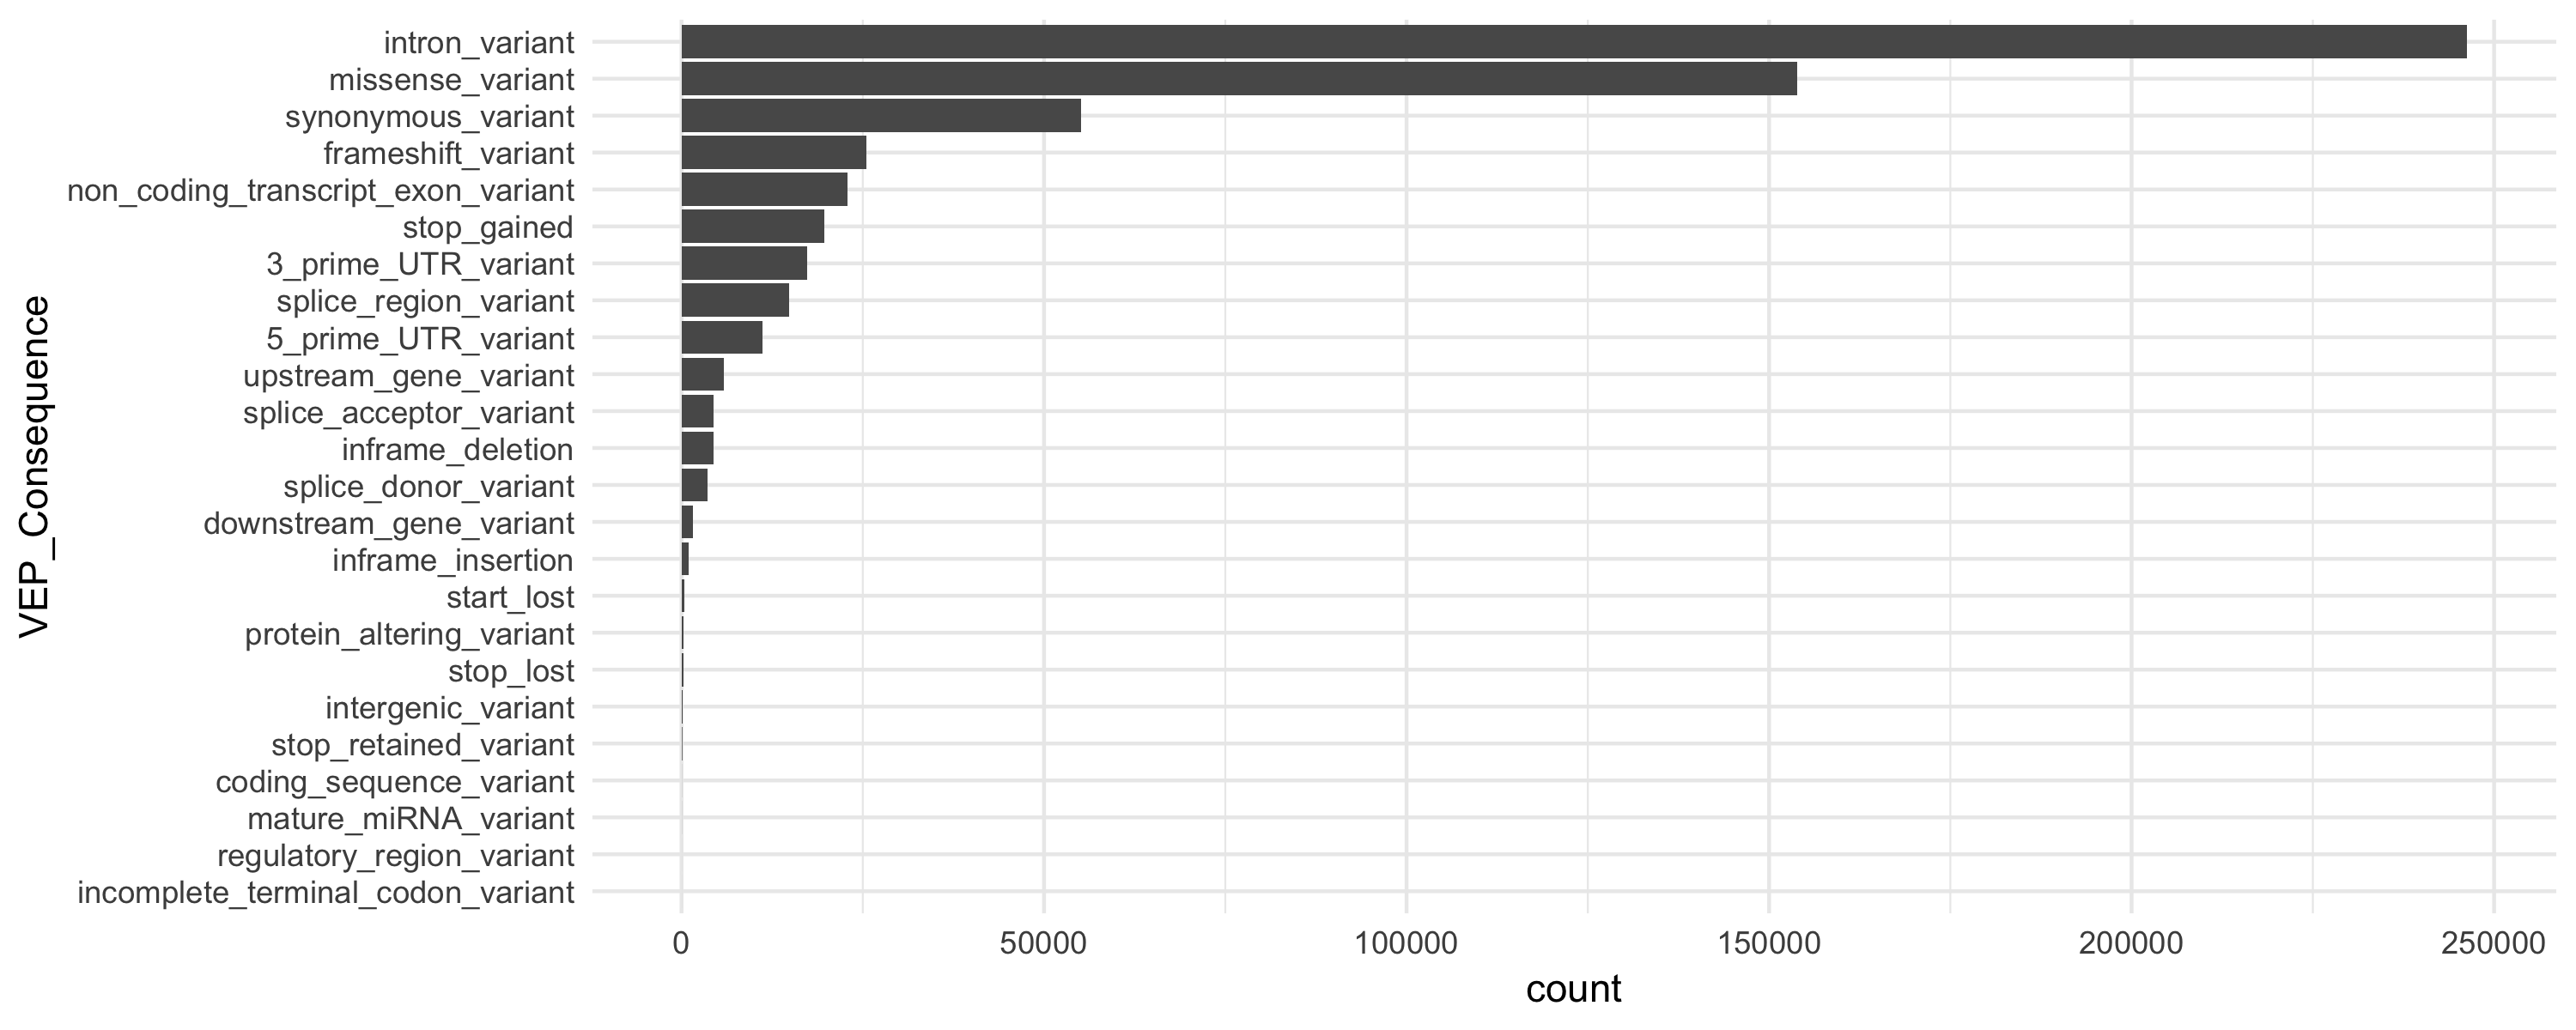

In [30]:
plot_histogram(impact, "VEP_Consequence", height = 4, flip = TRUE)

In [31]:
# [-375,418 rows] keep only the coding and splicing VEP_Consequence mutations
impact <- impact[impact$VEP_Consequence %in% c("missense_variant",
                                               "frameshift_variant",
                                               "stop_gained",
                                               "splice_acceptor_variant",
                                               "inframe_deletion",
                                               "splice_donor_variant",
                                               "inframe_insertion",
                                               "start_lost",
                                               "stop_lost"),]

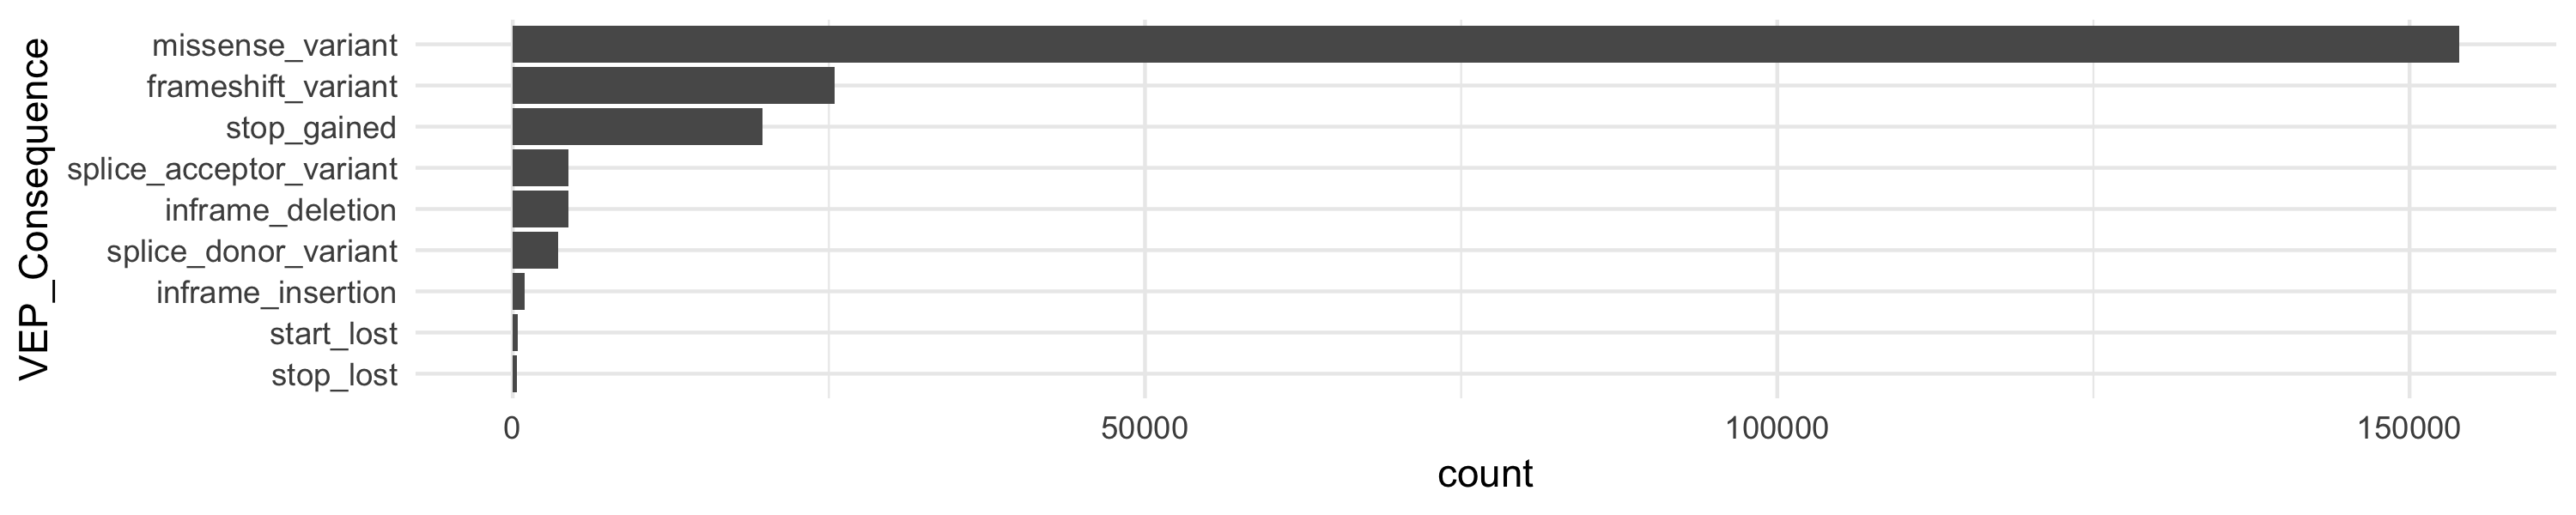

In [32]:
plot_histogram(impact, "VEP_Consequence", height = 2, flip = TRUE)

In [33]:
nrow(impact) # it was 588,547 before

[1] 213129

### [Remove] `confidence_class = UNKNOWN` or `confidence_class = OK_NOT_SO`

In [34]:
get_table(impact$confidence_class)

values,count,freq
AUTO_OK,187775,88.1%
UNLIKELY,13110,6.2%
MANUAL_OK,6748,3.2%
UNKNOWN,5464,2.6%
OK_NOT_SO,32,0%
-- total --,213129,100%


In [35]:
get_table(impact$Consequence[impact$confidence_class == "UNKNOWN"])
get_table(impact$VEP_Consequence[impact$confidence_class == "UNKNOWN"])

values,count,freq
intronic,2773,50.8%
exonic,1258,23%
synonymous_SNV,1024,18.7%
UTR3,167,3.1%
UTR5,118,2.2%
upstream,57,1%
Unknown,34,0.6%
stoploss_SNV,12,0.2%
splicing_noncanonical,11,0.2%
intergenic,4,0.1%


values,count,freq
missense_variant,4237,77.5%
frameshift_variant,421,7.7%
stop_gained,346,6.3%
splice_donor_variant,131,2.4%
splice_acceptor_variant,130,2.4%
inframe_deletion,77,1.4%
stop_lost,73,1.3%
start_lost,39,0.7%
inframe_insertion,10,0.2%
-- total --,5464,100%


In [36]:
# [-5,496 rows] remove rows having `confidence_class = UNKNOWN` or `confidence_class = OK_NOT_SO`
impact <- impact[! impact$confidence_class %in% c("UNKNOWN", "OK_NOT_SO"),]

### [Remove] `minor_contamination` > 0.01

In [37]:
print_count_and_proportion(nrow(impact[impact$minor_contamination > 0.01,]), nrow(impact))

[1] "9156 over 207633 (4.41%)"

In [38]:
# [-9,156 rows] remove the contaminated rows minor_contamination > 0.01
impact <- impact[impact$minor_contamination <= 0.01,]
# [-1 feature] remove the minor_contamination feature
impact["minor_contamination"] <- NULL

### [Remove] `n_depth` < 20

In [39]:
nrow(impact[impact$n_depth < 20,])

[1] 311

In [40]:
# [-311 rows] remove rows having n_depth < 20
impact <- impact[impact$n_depth >= 20,]

### [Remove] `t_alt_plus_count` + `t_alt_neg_count` != `t_alt_count`

In [41]:
nrow(impact[impact$t_alt_plus_count + impact$t_alt_neg_count != impact$t_alt_count,])

[1] 44

In [42]:
# [-44 rows] remove the rows having t_alt_plus_count + t_alt_neg_count != t_alt_count
impact <- impact[impact$t_alt_plus_count + impact$t_alt_neg_count == impact$t_alt_count,]

### [Create] new features: `sample_mut_key`, `patient_key`

In [43]:
# [+1 feature] create a sample mutation key feature to idenfity unique rows
impact$sample_mut_key <- paste(impact$Tumor_Sample_Barcode, impact$mut_key, sep = '_')

In [44]:
# [+1 feature] create a patient key feature to idenfity unique patient
impact$patient_key <- substr(impact$Tumor_Sample_Barcode, 1, 9)

### [Modify] `CDKN2Ap16INK4A` and `CDKN2Ap14ARF` reading frame

Two reading frame have been used for the gene `CDKN2A`:
* `CDKN2Ap16INK4A` is the "classic" reading frame for `CDKN2A`, the one used by OncoKB (see [OncoKB CDKN2A](http://oncokb.org/#/gene/CDKN2A))  
   → RefSeq. NM_000077.4  
   → [Homo sapiens cyclin dependent kinase inhibitor 2A (CDKN2A), transcript variant 1, mRNA](https://www.ncbi.nlm.nih.gov/nuccore/NM_000077.4)  
   → [Wikipedia article p16](https://en.wikipedia.org/wiki/P16)
* `CDKN2Ap14ARF` is an Alternative Reading Frame (ARF, as said in its name) for `CDKN2A`, not used by OncoKB  
  → RefSeq. NM_058195.3  
  → [Homo sapiens cyclin dependent kinase inhibitor 2A (CDKN2A), transcript variant 4, mRNA](https://www.ncbi.nlm.nih.gov/nuccore/NM_058195)  
  → [Wikipedia article p14arf](https://en.wikipedia.org/wiki/P14arf)
  
However, VEP thinks there's only one reading frame, the classic one `CDKN2A`. To correct this issue we:
* remove the mutations having the alternative reading frame and the classic reading frame in their tumor sample
* modify the `VEP_SYMBOL` of the mutations having the `CDKN2Ap14ARF` reading frame to `CDKN2Ap14ARF`

In [45]:
unique(impact$VEP_SYMBOL[impact$Hugo_Symbol %in% c("CDKN2Ap16INK4A", "CDKN2Ap14ARF")])

[1] "CDKN2A"

In [46]:
nrow(impact[impact$Hugo_Symbol == "CDKN2Ap16INK4A",])

[1] 1270

In [47]:
nrow(impact[impact$Hugo_Symbol == "CDKN2Ap14ARF",]) # mutations having the alternative reading data frame

dd <- impact %>% group_by(Tumor_Sample_Barcode) %>%
                 summarise(has_both_reading_frame = "CDKN2Ap14ARF" %in% Hugo_Symbol & "CDKN2Ap16INK4A" %in% Hugo_Symbol) %>%
                 filter(has_both_reading_frame)

# mutations having the alternative reading frame and the classic reading frame for this tumor sample
nrow(impact[impact$Hugo_Symbol == "CDKN2Ap14ARF" &
            impact$Tumor_Sample_Barcode %in% dd$Tumor_Sample_Barcode,]) 

[1] 758

[1] 713

We delete from `impact` the rows that are `CDKN2Ap14ARF` and have already been read in the classic reading frame:

In [48]:
# [-713 rows] Hugo_Symbol = CDKN2Ap14ARF and CDKN2Ap16INK4A in the tumor sample
impact <- impact[! (impact$Hugo_Symbol == "CDKN2Ap14ARF" & impact$Tumor_Sample_Barcode %in% dd$Tumor_Sample_Barcode),]

### [Remove] the duplicated `sample_mut_key` rows

Some tumor sample have twice the same mutation, we keep the one with the minimal depth, and when the depth are equal the one with the minimum vaf.

In [49]:
impact_redundant <- impact %>% group_by(sample_mut_key) %>% filter(n() >= 2)
nrow(impact_redundant)

[1] 96

In [50]:
impact_redundant %>% group_by(sample_mut_key) %>% filter(n() > 3)

Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,Tumor_Sample_Barcode,cDNA_change,HGVSp_Short,t_depth,t_vaf,t_alt_count,n_depth,n_vaf,n_alt_count,t_ref_plus_count,t_ref_neg_count,t_alt_plus_count,t_alt_neg_count,occurence_in_normals,confidence_class,sample_coverage,mut_key,VAG_VT,VAG_GENE,VAG_cDNA_CHANGE,VAG_PROTEIN_CHANGE,VAG_EFFECT,VEP_Consequence,VEP_SYMBOL,VEP_HGVSc,VEP_HGVSp,VEP_Amino_acids,VEP_VARIANT_CLASS,VEP_EXON,VEP_INTRON,VEP_IMPACT,VEP_CLIN_SIG,VEP_SIFT,VEP_PolyPhen,VEP_Existing_variation,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_genome_AC.AN_AFR,VEP_gnomAD_genome_AC.AN_AMR,VEP_gnomAD_genome_AC.AN_ASJ,VEP_gnomAD_genome_AC.AN_EAS,VEP_gnomAD_genome_AC.AN_FIN,VEP_gnomAD_genome_AC.AN_NFE,VEP_gnomAD_genome_AC.AN_OTH,VEP_gnomAD_exome_AC.AN_AFR,VEP_gnomAD_exome_AC.AN_AMR,VEP_gnomAD_exome_AC.AN_ASJ,VEP_gnomAD_exome_AC.AN_EAS,VEP_gnomAD_exome_AC.AN_FIN,VEP_gnomAD_exome_AC.AN_NFE,VEP_gnomAD_exome_AC.AN_OTH,sample_mut_key,patient_key


In [51]:
head(impact_redundant[order(impact_redundant$sample_mut_key),], 10)

Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,Tumor_Sample_Barcode,cDNA_change,HGVSp_Short,t_depth,t_vaf,t_alt_count,n_depth,n_vaf,n_alt_count,t_ref_plus_count,t_ref_neg_count,t_alt_plus_count,t_alt_neg_count,occurence_in_normals,confidence_class,sample_coverage,mut_key,VAG_VT,VAG_GENE,VAG_cDNA_CHANGE,VAG_PROTEIN_CHANGE,VAG_EFFECT,VEP_Consequence,VEP_SYMBOL,VEP_HGVSc,VEP_HGVSp,VEP_Amino_acids,VEP_VARIANT_CLASS,VEP_EXON,VEP_INTRON,VEP_IMPACT,VEP_CLIN_SIG,VEP_SIFT,VEP_PolyPhen,VEP_Existing_variation,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_genome_AC.AN_AFR,VEP_gnomAD_genome_AC.AN_AMR,VEP_gnomAD_genome_AC.AN_ASJ,VEP_gnomAD_genome_AC.AN_EAS,VEP_gnomAD_genome_AC.AN_FIN,VEP_gnomAD_genome_AC.AN_NFE,VEP_gnomAD_genome_AC.AN_OTH,VEP_gnomAD_exome_AC.AN_AFR,VEP_gnomAD_exome_AC.AN_AMR,VEP_gnomAD_exome_AC.AN_ASJ,VEP_gnomAD_exome_AC.AN_EAS,VEP_gnomAD_exome_AC.AN_FIN,VEP_gnomAD_exome_AC.AN_NFE,VEP_gnomAD_exome_AC.AN_OTH,sample_mut_key,patient_key
BRCA1,17,41234541,41234541,nonsynonymous_SNV,SNP,C,T,P-0000096-T01-IM3,c.4237G>A,p.E1413K,48,0.22917,11,103,0,0,15,22,5,6,0,UNLIKELY,1084,17_41234541_C_T,Sub,BRCA1,c.4237G>A,p.E1413K,non_synonymous_codon,missense_variant,BRCA1,ENST00000471181.2:c.4237G>A,ENSP00000418960.2:p.Glu1413Lys,E/K,SNV,12|24,NA,MODERATE,NA,tolerated(0.41),benign(0.138),CM123564,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,P-0000096-T01-IM3_17_41234541_C_T,P-0000096
BRCA1,17,41234541,41234541,nonsynonymous_SNV,SNP,C,T,P-0000096-T01-IM3,c.4237G>A,p.E1413K,1061,0.27333,290,346,0,0,358,413,128,162,0,AUTO_OK,1084,17_41234541_C_T,Sub,BRCA1,c.4237G>A,p.E1413K,non_synonymous_codon,missense_variant,BRCA1,ENST00000471181.2:c.4237G>A,ENSP00000418960.2:p.Glu1413Lys,E/K,SNV,12|24,NA,MODERATE,NA,tolerated(0.41),benign(0.138),CM123564,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,P-0000096-T01-IM3_17_41234541_C_T,P-0000096
JAK3,19,17942137,17942137,nonsynonymous_SNV,SNP,C,T,P-0000096-T01-IM3,c.2878G>A,p.E960K,50,0.36000,18,90,0,0,16,16,6,12,0,UNLIKELY,1084,19_17942137_C_T,Sub,JAK3,c.2878G>A,p.E960K,non_synonymous_codon,missense_variant,JAK3,ENST00000458235.1:c.2878G>A,ENSP00000391676.1:p.Glu960Lys,E/K,SNV,21|24,NA,MODERATE,NA,deleterious(0),benign(0.372),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,P-0000096-T01-IM3_19_17942137_C_T,P-0000096
JAK3,19,17942137,17942137,nonsynonymous_SNV,SNP,C,T,P-0000096-T01-IM3,c.2878G>A,p.E960K,698,0.44842,313,331,0,0,163,221,125,188,0,AUTO_OK,1084,19_17942137_C_T,Sub,JAK3,c.2878G>A,p.E960K,non_synonymous_codon,missense_variant,JAK3,ENST00000458235.1:c.2878G>A,ENSP00000391676.1:p.Glu960Lys,E/K,SNV,21|24,NA,MODERATE,NA,deleterious(0),benign(0.372),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,P-0000096-T01-IM3_19_17942137_C_T,P-0000096
PTPRS,19,5246019,5246019,nonsynonymous_SNV,SNP,C,G,P-0000096-T01-IM3,c.756G>C,p.M252I,70,0.14286,10,64,0,0,29,31,4,6,0,UNLIKELY,1084,19_5246019_C_G,Sub,PTPRS,c.756G>C,p.M252I,non_synonymous_codon,missense_variant,PTPRS,ENST00000357368.4:c.756G>C,ENSP00000349932.4:p.Met252Ile,M/I,SNV,10|38,NA,MODERATE,NA,tolerated(0.07),benign(0),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,P-0000096-T01-IM3_19_5246019_C_G,P-0000096
PTPRS,19,5246019,5246019,nonsynonymous_SNV,SNP,C,G,P-0000096-T01-IM3,c.756G>C,p.M252I,563,0.18295,103,227,0,0,154,306,40,63,0,AUTO_OK,1084,19_5246019_C_G,Sub,PTPRS,c.756G>C,p.M252I,non_synonymous_codon,missense_variant,PTPRS,ENST00000357368.4:c.756G>C,ENSP00000349932.4:p.Met252Ile,M/I,SNV,10|38,NA,MODERATE,NA,tolerated(0.07),benign(0),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,P-0000096-T01-IM3_19_5246019_C_G,P-0000096
RHOA,3,49412884,49412884,nonsynonymous_SNV,SNP,C,T,P-0000096-T01-IM3,c.139G>A,p.E47K,58,0.39655,23,100,0,0,20,15,12,11,0,UNLIKELY,1084,3_49412884_C_T,Sub,RHOA,c.139G>A,p.E47K,non_synonymous_codon,missense_variant,RHOA,ENST00000418115.1:c.139G>A,ENSP00000400175.1:p.Glu47Lys,E/K,SNV,2|5,NA,MODERATE,NA,deleterious(0.04),possibly_damaging(0.903),NA,NA,NA,NA,NA,NA,

In [52]:
impact_redundant_to_delete <- impact_redundant %>% group_by(sample_mut_key) %>% filter(t_depth == min(t_depth)) %>% filter(t_vaf == min(t_vaf))
nrow(impact_redundant_to_delete)

[1] 48

In [53]:
# [-48 rows] duplicated mutation for the same sample_mut_key
impact <- impact[! (impact$sample_mut_key %in% impact_redundant_to_delete$sample_mut_key &
                    impact$t_depth %in% impact_redundant_to_delete$t_depth &
                    impact$t_vaf %in% impact_redundant_to_delete$t_vaf),]

### [None] Remove hypermutated patients?

In [54]:
tumor_summary <- impact %>% group_by(Tumor_Sample_Barcode) %>% summarise(number_of_mutations = n())
head(tumor_summary)

Tumor_Sample_Barcode,number_of_mutations
None-T01-IM6,6
P-0000012-T02-IM3,1
P-0000012-T03-IM3,30
P-0000023-T01-IM3,5
P-0000024-T01-IM3,6
P-0000025-T01-IM3,1


In [55]:
nrow(tumor_summary)
summary(tumor_summary$number_of_mutations)
nrow(tumor_summary[tumor_summary$number_of_mutations >= 100,])

[1] 22747

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   3.000   4.000   8.676   8.000 527.000 

[1] 141

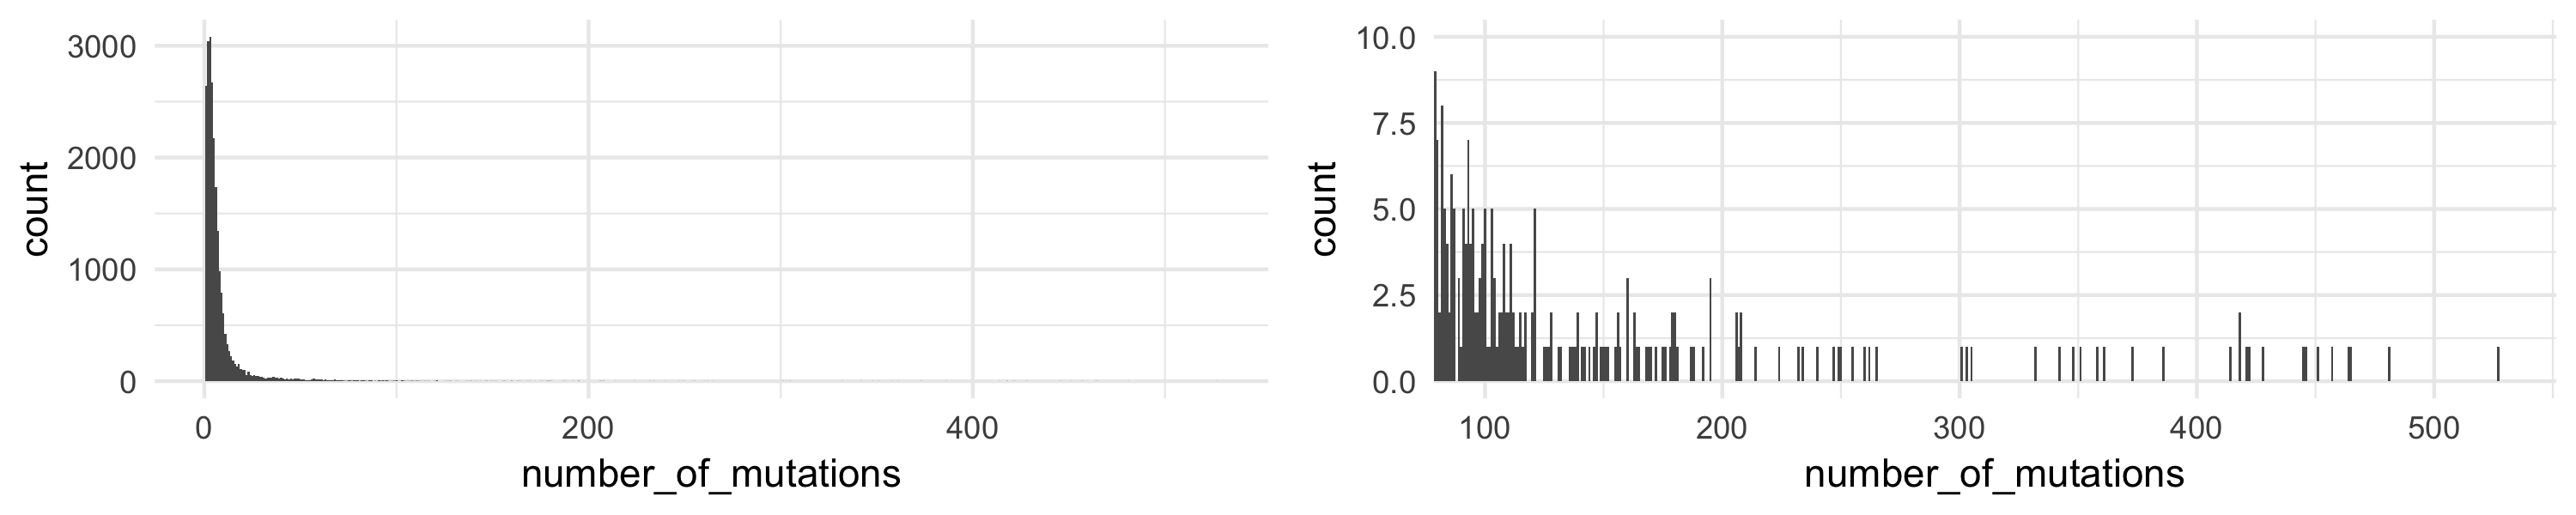

In [56]:
plot1 <- ggplot(tumor_summary) + geom_histogram(aes(number_of_mutations), binwidth = 1)
plot2 <- plot1 + coord_cartesian(xlim = c(100, 530), ylim = c(0, 10))
plot_side_by_side(plot1, plot2)

We decided not to remove any hypermutated patient.

### [Remove] DNP and TNP counted twice

Some `SNP` are overlapped by a `DNP` or a `TNP`, we find them and remove them.

In [57]:
overlapping_risk_dnp_or_tnp <- as.data.frame(impact %>% group_by(Tumor_Sample_Barcode, VEP_SYMBOL) %>%
                                             filter(n() > 1 &
                                                    "SNP" %in% Variant_Type &
                                                    ("DNP" %in% Variant_Type |
                                                     "TNP" %in% Variant_Type)))

nrow(overlapping_risk_dnp_or_tnp)

[1] 6774

In [58]:
find_overlapping_dnp_or_tnp <- function(data, tsb, chr, start) {
    result <- data %>% filter(Tumor_Sample_Barcode == tsb &
                              Chromosome == chr &
                              ((Variant_Type == "DNP" & (Start_Position == start | Start_Position == start - 1) |
                               (Variant_Type == "TNP" & (Start_Position == start | Start_Position == start - 1 | Start_Position == start - 2)))))

    if (nrow(result) == 0)
        return ("no")
    else
        return (toString(paste(nrow(result), result$Start_Position, result$Reference_Allele, result$Tumor_Seq_Allele2, result$t_vaf, result$confidence_class, sep = ' | ')))
}

In [59]:
overlapping_dnp_or_tnp <- overlapping_risk_dnp_or_tnp %>% filter(Variant_Type == "SNP") %>%
                                                          group_by(sample_mut_key) %>%
                                                          mutate(overlap = find_overlapping_dnp_or_tnp(overlapping_risk_dnp_or_tnp, Tumor_Sample_Barcode, Chromosome, Start_Position)) %>%
                                                          filter(overlap != "no") %>%
                                                          select(sample_mut_key, VEP_SYMBOL, Start_Position, Variant_Type, Reference_Allele, Tumor_Seq_Allele2, Tumor_Sample_Barcode, t_vaf, confidence_class, overlap)

nrow(overlapping_dnp_or_tnp)

[1] 3150

Most of them were classified as `UNLIKELY`:

In [60]:
get_table(overlapping_dnp_or_tnp$confidence_class)

values,count,freq
UNLIKELY,3063,97.2%
AUTO_OK,77,2.4%
MANUAL_OK,10,0.3%
-- total --,3150,100%


Except for a few, the `SNP` and the overlapping `DNP/TNP` have really close `t_vaf`:

In [61]:
overlapping_dnp_or_tnp$other_t_vaf <- sapply(overlapping_dnp_or_tnp$overlap, function(x) as.numeric(strsplit(x, ' \\| ')[[1]][5]))

In [62]:
nrow(overlapping_dnp_or_tnp)
get_table(abs(overlapping_dnp_or_tnp$t_vaf - overlapping_dnp_or_tnp$other_t_vaf) > 0.01)
get_table(abs(overlapping_dnp_or_tnp$t_vaf - overlapping_dnp_or_tnp$other_t_vaf) > 0.05)

[1] 3150

values,count,freq
FALSE,3075,97.6%
TRUE,75,2.4%
-- total --,3150,100%


values,count,freq
FALSE,3142,99.7%
TRUE,8,0.3%
-- total --,3150,100%


In [63]:
# [-3151 rows] SNV found as DNP or TNP
impact <- impact[! impact$sample_mut_key %in% overlapping_dnp_or_tnp$sample_mut_key,]

## Process raw features

### [Modify] deal with `NA` values

In [64]:
count_na <- function(data) {
    return (sum(is.na(data)))
}

In [65]:
replace_na <- function(data, feature_name, replace_value){
    data[is.na(data[,feature_name]), feature_name] <- replace_value
    
    return (data)
}

#### VAG

In [66]:
for (c in vag_colnames)
    print(sprintf("%17s: %d", c, count_na(impact[,c])))

[1] "           VAG_VT: 0"
[1] "         VAG_GENE: 112"
[1] "  VAG_cDNA_CHANGE: 166"
[1] "VAG_PROTEIN_CHANGE: 166"
[1] "       VAG_EFFECT: 112"


In [67]:
impact <- replace_na(impact, "VAG_GENE"          , "unknown")
impact <- replace_na(impact, "VAG_cDNA_CHANGE"   , "unknown")
impact <- replace_na(impact, "VAG_PROTEIN_CHANGE", "unknown")
impact <- replace_na(impact, "VAG_EFFECT"        , "unknown")

#### VEP

In [68]:
for (c in vep_colnames)
    print(sprintf("%17s: %d", c, count_na(impact[,c])))

[1] "  VEP_Consequence: 0"
[1] "       VEP_SYMBOL: 0"
[1] "        VEP_HGVSc: 5"
[1] "        VEP_HGVSp: 7175"
[1] "  VEP_Amino_acids: 7158"
[1] "VEP_VARIANT_CLASS: 0"
[1] "         VEP_EXON: 5850"
[1] "       VEP_INTRON: 187087"


In [69]:
impact[is.na(impact$VEP_HGVSc),]

Hugo_Symbol    Chromosome Start_Position End_Position
92105  CDKN2Ap16INK4A 9          21974658       21974895    
286621 MAPK3          16         30134458       30135078    
287992 SMAD3          15         67457371       67457373    
355886 MSH2           2          47630177       47630419    
411327 AURKB          17          8108003        8108479    
       Consequence            Variant_Type
92105  splicing               DEL         
286621 nonsynonymous_SNV      DEL         
287992 nonframeshift_deletion DEL         
355886 nonsynonymous_SNV      DEL         
411327 splicing               DEL         
       Reference_Allele                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
92105  CTGCAGACCCTCTACCCACCTGGATCGGCCTCCGACCGTAACTATTCGGTGCGTTGGGCAGCGCCCCCGCCTCCAGCAGCGCCCGCACCTCCTCTACCCGACCCCGGGCCGCGGCCGTGGCCAGCCAGTCAGCCGAAGGCTCCATGCTGCTCCCCGCCGCCGGCTCCATGCTGCTCCCCGCCGCCCGCTGCCTGCTCTCCCCCTCTCCGCAGCCGCCGAGCGCACGCGGTCCGCCCCA                                                                                                                                                                                                                                                                                                                                                                                               
286621 GGACCCCCGGGCCGACCCCCTCGGTTCTACGGGGCTCCCCGCCCCCGCCCCCCTGAGCCGCCGCCGCCGCCATCTCCACTCCTCCCCTCCCACCGCCCTCCTCCCCACGGCGGCCCCGCCCGAGGCCCCGCCCCTTCCCGCCTGCCTGTCACCCGCAGGGCCGCGCGCGCCAGGCCCCGCCCTTGCCCCGGCCCCGCGTGGGCCTGGAGCTGTCACGTGACCCGCCCCGCGCGCGCCCGCCCTTCTTGCCCCAGGTTCGGGGGCCATGGGTCCCTGCGGGCTCCGCGGCCTCCAGGTCACCGGGAGGTTCGGCAGCGCCGCCTCGGAGACTGTCCTCACCCTCCCCTCGATGGCGAAGCGGCCAGGGCGTGACCTACCAGAGCCACCCAGCCAATGTATGCGGCAGCCCACCAGAACCTGGGCCCGGGATCACCCTAGGTTAAAAATAATGTTCTAATAAATGGATCAAATTTTACAGATGGAGAATCTGAGAGTTAGGTTTACTAACTTGGGTAAGGTCACTAGTAGTGACAGCTGAGACTCAAAATGGTGTCTTCTGACACAGAGACTCTTTCTAATTCCATGCCTCTCAGAGTCCTAGACTGTTTTTATTTTATTATA
287992 GAA                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
355886 GACTCCCACCCACCGAAACGCAGCCCTGGAAGCTGATTGGGTGTGGTCGCCGTGGCCGGACGCCGCTCGGGGGACGTGGGAGGGGAGGCGGGAAACAGCTTAGTGGGTGTGGGGTCGCGCATTTTCTTCAACCAGGAGGTGAGGAGGTTTCGACATGGCGGTGCAGCCGAAGGAGACGCTGCAGTTGGAGAGCGCGGCCGAGGTCGGCTTCGTGCGCTTCTTTCAGGGCATGCCGGAGAAGCC                                                                                                                                                                                                                                                                                                                                                                                          
411327 GAACAGCTTCCTCCACAGCAAAGCCTCCACCTAGAAACATCTACACTCATGAGTACAAAAAGCTTCAGCCTTTATTAAACAAAGGAGGAGGTAGAAAACAGATAAGGGAACAGTTAGGGATCCCTTCTTTCCCCTATACATACACAGACATACAAACACACGCACCCGAGTGAATGACAGGGACCATCAGGCGACAGATTGAAGGGCAGAGGGAGGCAGCACCCTCCGAGA

7280 mutations have `VEP_HGVSp` = `NA`, almost all of them being splicing mutations:

In [70]:
get_table(impact$VEP_Consequence[is.na(impact$VEP_HGVSp)])

values,count,freq
splice_acceptor_variant,3838,53.5%
splice_donor_variant,3175,44.3%
frameshift_variant,87,1.2%
stop_lost,41,0.6%
start_lost,20,0.3%
inframe_insertion,6,0.1%
inframe_deletion,5,0.1%
stop_gained,3,0%
-- total --,7175,100%


7280 mutations have `VEP_Amino_acids` = `NA`, most of them being the one having `VEP_HGVSp = NA`:

In [71]:
count_na(impact$VEP_Amino_acids)
table(impact$mut_key[is.na(impact$VEP_Amino_acids)] %in% impact$mut_key[is.na(impact$VEP_HGVSp)])

[1] 7158


FALSE  TRUE 
   85  7073 

In [72]:
get_table(impact$VEP_Consequence[is.na(impact$VEP_Amino_acids) & ! is.na(impact$VEP_HGVSp)])

values,count,freq
splice_acceptor_variant,85,100%
-- total --,85,100%


In [73]:
nrow(impact[impact$VEP_Consequence == "splice_acceptor_variant" & ! is.na(impact$VEP_HGVSp) & impact$VEP_HGVSp != "unknown",])
nrow(impact[impact$VEP_Consequence == "splice_donor_variant" & ! is.na(impact$VEP_HGVSp) & impact$VEP_HGVSp != "unknown",])

[1] 112

[1] 0

In [74]:
impact <- replace_na(impact, "VEP_HGVSc"      , "unknown")
impact <- replace_na(impact, "VEP_HGVSp"      , "unknown")
impact <- replace_na(impact, "VEP_Amino_acids", "unknown")

`VEP_EXON` and `VEP_INTRON` are complementary: when one is `NA` the other has a value, except for 41 cases.

In [75]:
get_table(is.na(impact$VEP_EXON) & is.na(impact$VEP_INTRON))

values,count,freq
FALSE,194170,100%
TRUE,41,0%
-- total --,194211,100%


#### VEP additional

In [76]:
for (c in vep_add_colnames)
    print(sprintf("%22s: %d", c, count_na(impact[,c])))

[1] "            VEP_IMPACT: 0"
[1] "          VEP_CLIN_SIG: 164736"
[1] "              VEP_SIFT: 55800"
[1] "          VEP_PolyPhen: 54975"
[1] "VEP_Existing_variation: 101303"
[1] "        VEP_COSMIC_CNT: 130629"


`NA` values might correspond to not found, we replace them by `"unknown"`:

In [77]:
impact <- replace_na(impact, "VEP_CLIN_SIG"          , "unknown")
impact <- replace_na(impact, "VEP_SIFT"              , "unknown")
impact <- replace_na(impact, "VEP_PolyPhen"          , "unknown")
impact <- replace_na(impact, "VEP_Existing_variation", "unknown")
impact <- replace_na(impact, "VEP_COSMIC_CNT"        , "unknown")

#### VEP gnomAD

In [78]:
for (c in vep_gnomad_colnames)
    print(sprintf("%27s: %d", c, count_na(impact[,c])))

[1] "              VEP_gnomAD_AF: 155362"
[1] "VEP_gnomAD_genome_AC.AN_AFR: 180088"
[1] "VEP_gnomAD_genome_AC.AN_AMR: 180088"
[1] "VEP_gnomAD_genome_AC.AN_ASJ: 180088"
[1] "VEP_gnomAD_genome_AC.AN_EAS: 180088"
[1] "VEP_gnomAD_genome_AC.AN_FIN: 180088"
[1] "VEP_gnomAD_genome_AC.AN_NFE: 180088"
[1] "VEP_gnomAD_genome_AC.AN_OTH: 180088"
[1] " VEP_gnomAD_exome_AC.AN_AFR: 145767"
[1] " VEP_gnomAD_exome_AC.AN_AMR: 145767"
[1] " VEP_gnomAD_exome_AC.AN_ASJ: 145767"
[1] " VEP_gnomAD_exome_AC.AN_EAS: 145767"
[1] " VEP_gnomAD_exome_AC.AN_FIN: 145767"
[1] " VEP_gnomAD_exome_AC.AN_NFE: 145767"
[1] " VEP_gnomAD_exome_AC.AN_OTH: 145767"


`NA` values might correspond to not found, we replace them by a null allele value, or by `0 | 0` for the Allele count | Total number of alleles:

In [79]:
impact <- replace_na(impact, "VEP_gnomAD_AF", 0.0)

for (c in vep_gnomad_colnames[grepl("_AC.AN_", vep_gnomad_colnames)])
    impact <- replace_na(impact, c, " 0 | 0")

### [Modify] `occurence_in_normals` -> `frequency_in_normals`

In [80]:
dd <- head(unique(impact$occurence_in_normals), 10)
dd[dd == '0'] <- "0;0"
dd <- data.frame(dd, sapply(dd, function(s) as.double(strsplit(s, split = ';')[[1]][2])), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
0;0,0.000
0;0,0.000
1;0.026,0.026
6;0.158,0.158
3;0.079,0.079
4;0.105,0.105
7;0.184,0.184
2;0.051,0.051
6;0.154,0.154
3;0.077,0.077


In [81]:
# [~ every rows] occurence_in_normals -> frequency_in_normals
impact$occurence_in_normals[impact$occurence_in_normals == '0'] <- "0;0"
impact$frequency_in_normals <- sapply(impact$occurence_in_normals,
                                      function(s) as.double(strsplit(s, split = ';')[[1]][2]))
impact$occurence_in_normals <- NULL

### [Modify] `VEP_HGVSc`

In [82]:
dd <- head(impact$VEP_HGVSc, 10)
dd <- data.frame(dd, sapply(dd, function(x) strsplit(x, ':')[[1]][2]), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
ENST00000269305.4:c.766A>C,c.766A>C
ENST00000262741.5:c.894C>G,c.894C>G
ENST00000350721.4:c.7292G>T,c.7292G>T
ENST00000257290.5:c.1393T>A,c.1393T>A
ENST00000281708.4:c.1237-1G>T,c.1237-1G>T
ENST00000281708.4:c.181G>T,c.181G>T
ENST00000264932.6:c.1444C>T,c.1444C>T
ENST00000399503.3:c.904G>T,c.904G>T
ENST00000399503.3:c.2087+2T>G,c.2087+2T>G
ENST00000439151.2:c.5338G>T,c.5338G>T


In [83]:
# [~ every rows] VEP_HGVSc -> readable VEP_HGVSc
impact$VEP_HGVSc <- sapply(impact$VEP_HGVSc, function(x) strsplit(x, ':')[[1]][2])
impact <- replace_na(impact, "VEP_HGVSc", "unknown") # 5 NA values that we need to handle

### [Modify] `VEP_HGVSp`

In [84]:
get_HGVSp_from_vep <- function(HGVSp_string) {
    
    if (HGVSp_string == "unknown")
        return ("unknown")
    
    HGVSp_string <- strsplit(HGVSp_string, ':')[[1]][2]
    
    protein_long_name <- c('Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Glu', 'Gln', 'Gly', 'His', 'Ile', 'Leu', 'Lys',
                           'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val')
    protein_short_name <- c('A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K',
                            'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V')
    
    for (name in protein_long_name)
        HGVSp_string <- gsub(name, protein_short_name[match(name, protein_long_name)], HGVSp_string)
    
    HGVSp_string <- gsub('Ter', '*', HGVSp_string)
    HGVSp_string <- gsub('%3D', '=', HGVSp_string)
    
    return (HGVSp_string)
}

In [85]:
dd <- head(impact$VEP_HGVSp, 10)
dd <- data.frame(dd, sapply(dd, get_HGVSp_from_vep), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
ENSP00000269305.4:p.Thr256Pro,p.T256P
ENSP00000262741.5:p.Ile298Met,p.I298M
ENSP00000343741.4:p.Arg2431Met,p.R2431M
ENSP00000257290.5:p.Leu465Met,p.L465M
unknown,unknown
ENSP00000281708.3:p.Gly61Ter,p.G61*
ENSP00000264932.6:p.Pro482Ser,p.P482S
ENSP00000382423.3:p.Glu302Ter,p.E302*
unknown,unknown
ENSP00000395929.2:p.Val1780Phe,p.V1780F


In [86]:
# [~ every rows] VEP_HGVSp -> readable VEP_HGVSp
impact$VEP_HGVSp <- sapply(impact$VEP_HGVSp, get_HGVSp_from_vep)

### [Modify] `VEP_SIFT`

In [87]:
dd <- head(unique(impact$VEP_SIFT), 10)
dd <- data.frame(dd,
                 sapply(dd, function(x) strsplit(x, '\\(')[[1]][1]),
                 sapply(dd, function(x) as.numeric(gsub(')', '', strsplit(x, '\\(')[[1]][2]))),
                 row.names = NULL)
colnames(dd) <- c("old", "new1", "new2")
dd

old,new1,new2
deleterious(0),deleterious,0.00
deleterious(0.01),deleterious,0.01
unknown,unknown,NA
tolerated_low_confidence(0.12),tolerated_low_confidence,0.12
tolerated(0.4),tolerated,0.40
tolerated(0.17),tolerated,0.17
deleterious(0.02),deleterious,0.02
deleterious_low_confidence(0),deleterious_low_confidence,0.00
tolerated_low_confidence(0.1),tolerated_low_confidence,0.10
tolerated(0.08),tolerated,0.08


In [88]:
# [~ every rows] VEP_SIFT -> VEP_SIFT_class & VEP_SIFT_score
impact$VEP_SIFT_class <- sapply(impact$VEP_SIFT, function(x) strsplit(x, '\\(')[[1]][1])
impact$VEP_SIFT_score <- sapply(impact$VEP_SIFT, function(x) as.numeric(gsub(')', '', strsplit(x, '\\(')[[1]][2])))
impact$VEP_SIFT <- NULL

Warning, there is `NA` values in `VEP_SIFT_score` for `unknown`.

### [Modify] `VEP_PolyPhen`

In [89]:
dd <- head(unique(impact$VEP_PolyPhen), 10)
dd <- data.frame(dd,
                 sapply(dd, function(x) strsplit(x, '\\(')[[1]][1]),
                 sapply(dd, function(x) as.numeric(gsub(')', '', strsplit(x, '\\(')[[1]][2]))),
                 row.names = NULL)
colnames(dd) <- c("old", "new1", "new2")
dd

old,new1,new2
probably_damaging(0.999),probably_damaging,0.999
benign(0.277),benign,0.277
probably_damaging(0.997),probably_damaging,0.997
probably_damaging(0.965),probably_damaging,0.965
unknown,unknown,NA
benign(0.005),benign,0.005
probably_damaging(0.952),probably_damaging,0.952
possibly_damaging(0.738),possibly_damaging,0.738
probably_damaging(0.995),probably_damaging,0.995
possibly_damaging(0.472),possibly_damaging,0.472


In [90]:
# [~ every rows] VEP_PolyPhen -> VEP_PolyPhen_class & VEP_PolyPhen_score
impact$VEP_PolyPhen_class <- sapply(impact$VEP_PolyPhen, function(x) strsplit(x, '\\(')[[1]][1])
impact$VEP_PolyPhen_score <- sapply(impact$VEP_PolyPhen, function(x) as.numeric(gsub(')', '', strsplit(x, '\\(')[[1]][2])))
impact$VEP_PolyPhen <- NULL

Warning, there is `NA` values in `VEP_PolyPhen_score` for `unknown`.

### [Modify] `VEP_Existing_variation` -> `VEP_in_dbSNP`

A mutation has the feature`VEP_in_dbSNP = TRUE` when we found a dnSNP id in the `VEP_Existing_variation` column.

In [91]:
dd <- head(unique(impact$VEP_Existing_variation), 10)
dd <- data.frame(dd, grepl("rs", dd), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
CM102355&CD120857&TP53_g.13403A>C&COSM44544&COSM44662&COSM45526&COSM45830,FALSE
unknown,FALSE
rs759327414&COSM1039347,TRUE
rs775630094&COSM3782296&COSM3782297&COSM3782298&COSM3782299&COSM3782300&COSM3782301,TRUE
COSM5570654&COSM5570655&COSM5570656,FALSE
COSM3693022&COSM4784258,FALSE
COSM1589625&COSM990757,FALSE
COSM5586358&COSM5586359,FALSE
COSM4599799,FALSE
COSM44939&COSM46097,FALSE


In [92]:
# [~ every rows] VEP_Existing_variation -> VEP_in_dbSNP
impact$VEP_in_dbSNP <- grepl("rs", impact$VEP_Existing_variation)
impact$VEP_Existing_variation <- NULL

In [93]:
get_table(impact$VEP_in_dbSNP)

values,count,freq
FALSE,138830,71.5%
TRUE,55381,28.5%
-- total --,194211,100%


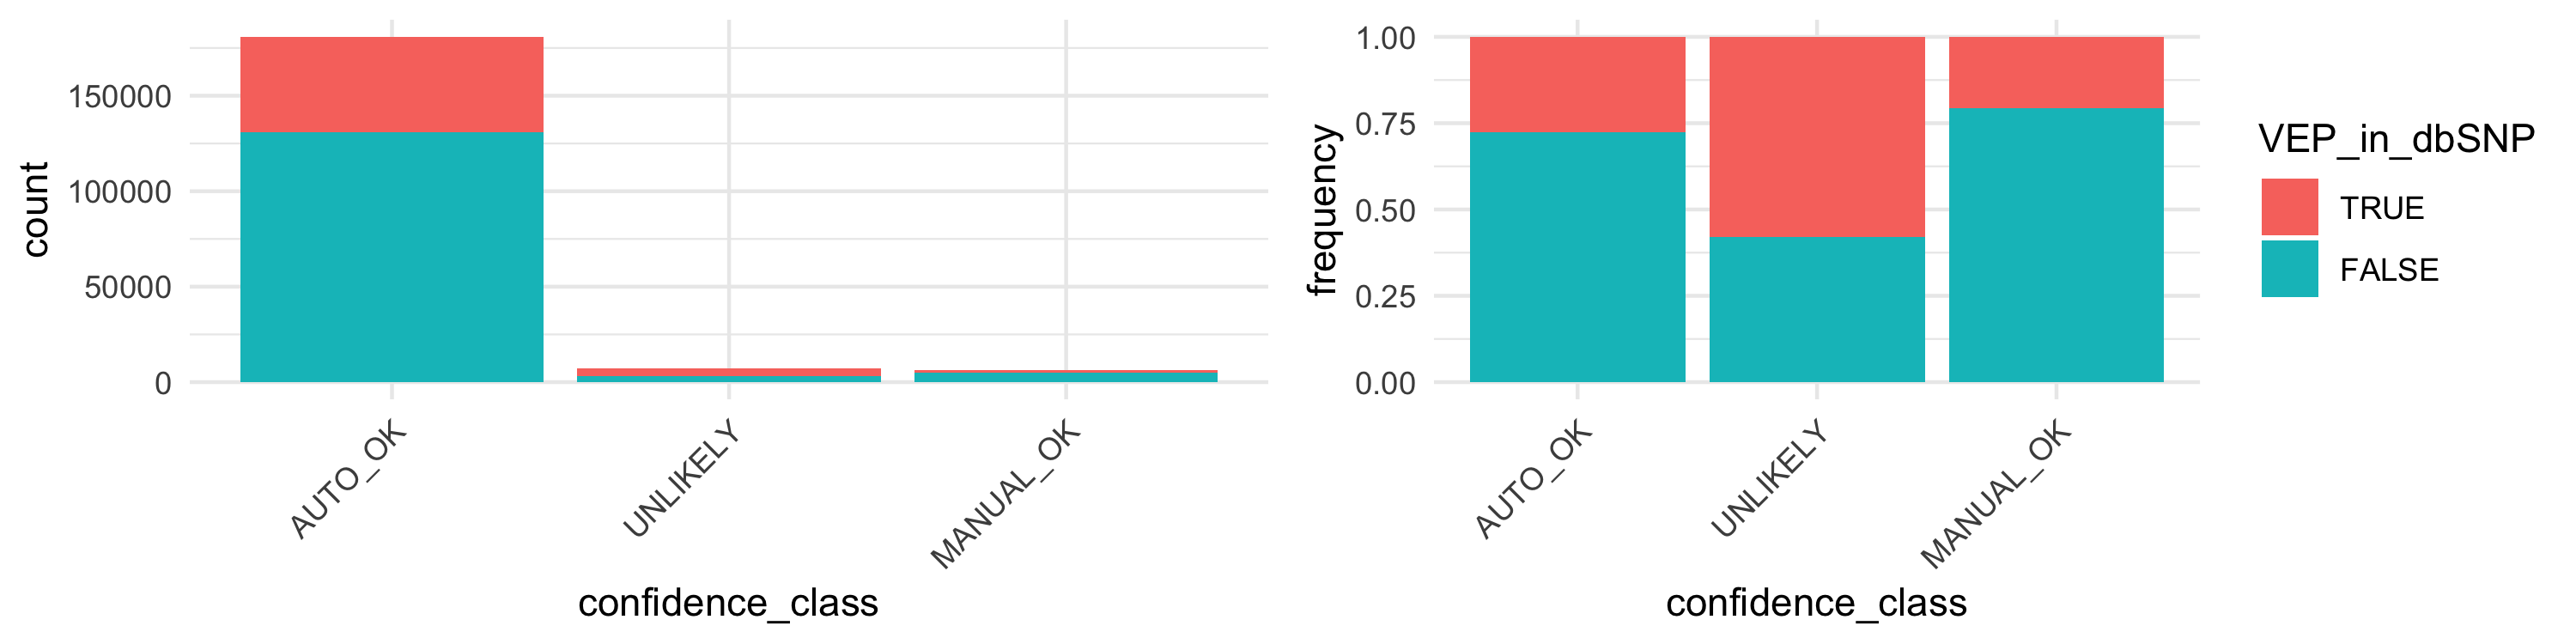

In [94]:
plot_contingency_table_as_histograms(impact, "confidence_class", "VEP_in_dbSNP", height = 2.5)

We clearly see the germline `t_vaf` for the `UNLIKELY` class.

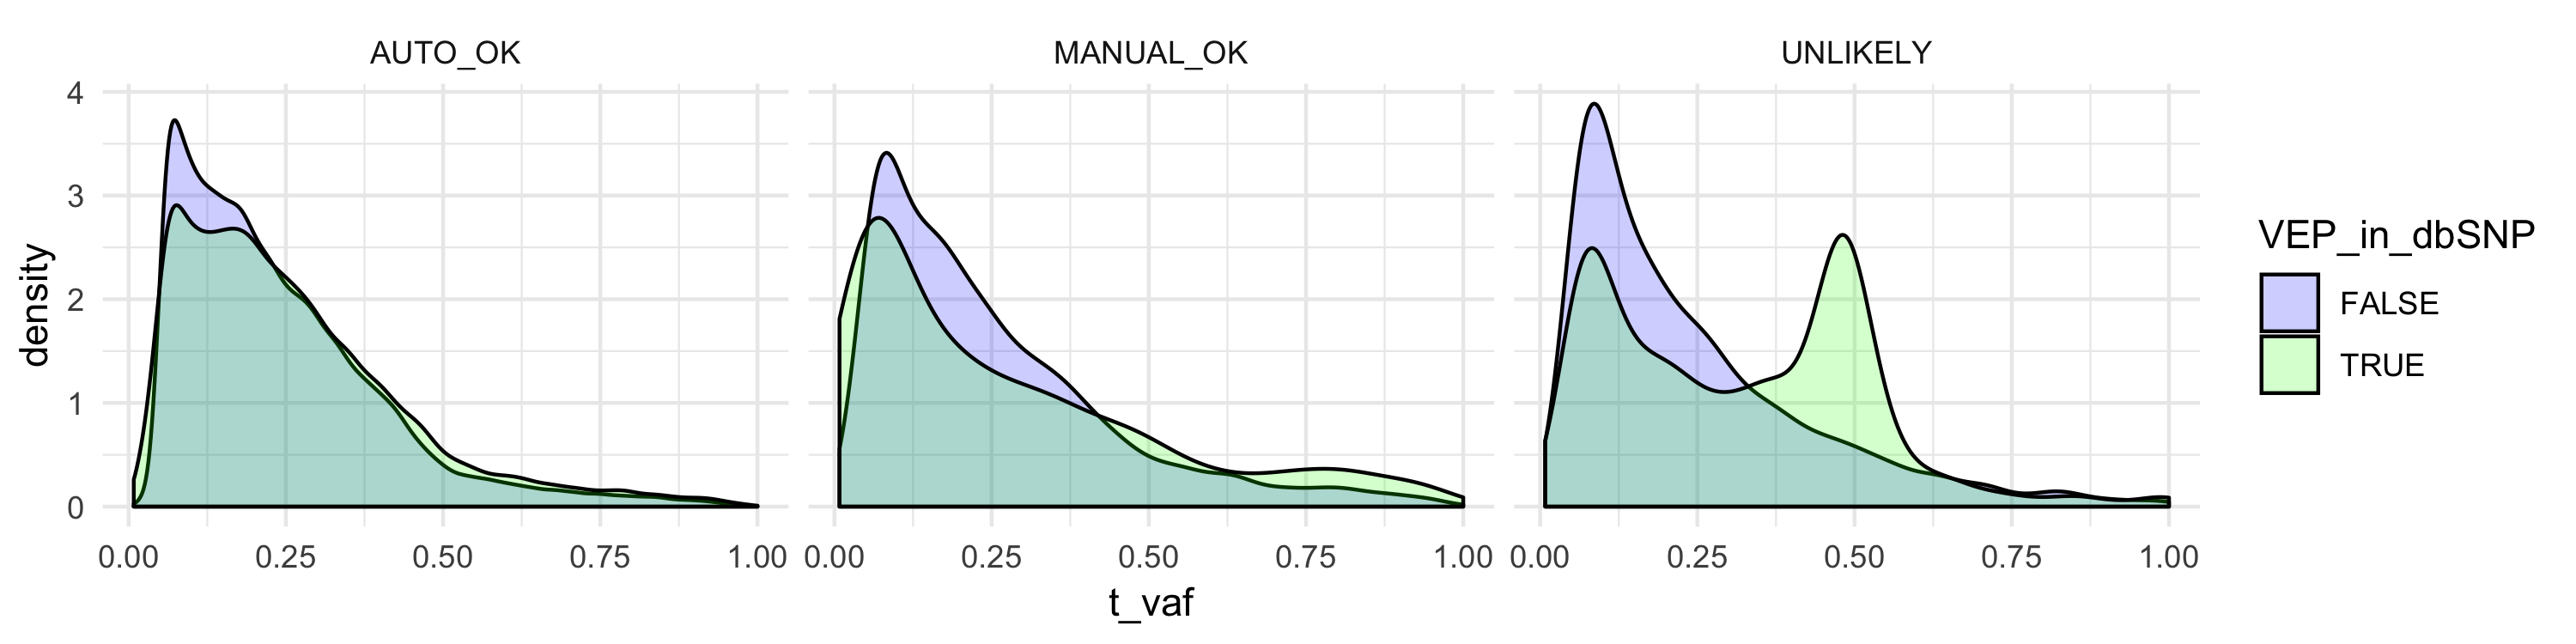

In [95]:
plot_density(impact, "t_vaf", fill = "VEP_in_dbSNP", height = 2.5) + facet_grid(col = vars(confidence_class))

### [Modify] `VEP_COSMIC_CNT`

In [96]:
get_cosmic_count_from_vep <- function(cosmic_count_string) {
    if (cosmic_count_string == "unknown")
        return (0)
    else
        return (sum(as.numeric(strsplit(cosmic_count_string, '&')[[1]])))
}

dd <- head(unique(impact$VEP_COSMIC_CNT), 10)
dd <- data.frame(dd, sapply(dd, get_cosmic_count_from_vep), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
1,1
unknown,0
1&1&1&1&1&1,6
1&1&1,3
1&1,2
53,53
158,158
19&21&14,54
229&230&200&230&179&789,1857
42&170,212


In [97]:
# [~ every rows] VEP_COSMIC_CNT -> readable VEP_COSMIC_CNT
impact$VEP_COSMIC_CNT <- sapply(impact$VEP_COSMIC_CNT, get_cosmic_count_from_vep)

### [Modify] VEP_CLIN_SIG

In [98]:
get_table(impact$VEP_CLIN_SIG) %>% filter(count >= 200)

values,count,freq
unknown,164736,84.8%
likely_pathogenic&pathogenic,8307,4.3%
not_provided&likely_pathogenic&pathogenic,4874,2.5%
pathogenic,3610,1.9%
likely_pathogenic,3211,1.7%
uncertain_significance,3207,1.7%
uncertain_significance&likely_pathogenic,826,0.4%
uncertain_significance&pathogenic,625,0.3%
not_provided,618,0.3%
likely_pathogenic&pathogenic&drug_response,592,0.3%


We group the values with the following rules:
* We consider 3 big different classes:
    * `pathogenic`: `pathogenic`, `likely_pathogenic`, `drug_response`, `risk_factor`
    * `benign`: `benign`, `likely_benign`
    * `unknown`: `NA` (has been previously replaced by `unknown`), `not_provided`, `uncertain_significance`
* A mutation having both `pathogenic` and `benign` classes is classified as `unknown`
* A mutation having a strong class (`pathogenic` or `benign`) and `unknown` class is classified as the strong class

In [99]:
get_simplified_clin_sig <- function(clin_sig_string) {
    if (clin_sig_string == "unknown")
        return ("unknown")
    else {
        tags <- unique(strsplit(clin_sig_string, '&')[[1]])
        
        tags <- gsub('likely_pathogenic', 'pathogenic', tags)
        tags <- gsub('drug_response'    , 'pathogenic', tags)
        tags <- gsub('risk_factor'      , 'pathogenic', tags)
        tags <- gsub('likely_benign'    , 'benign'    , tags)
        
        tags <- unique(tags)
        
        tags <- tags[! tags %in% c("not_provided", "uncertain_significance", "other")]
        
        if (length(tags) == 0 || length(tags) > 1)
            return ("unknown")
        else
            return (tags)
    }
}

In [100]:
dd <- head(unique(impact$VEP_CLIN_SIG), 20)
dd <- data.frame(dd, sapply(dd, get_simplified_clin_sig), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
unknown,unknown
likely_pathogenic&pathogenic,pathogenic
uncertain_significance&benign,benign
uncertain_significance,unknown
uncertain_significance&likely_pathogenic&pathogenic,pathogenic
pathogenic,pathogenic
uncertain_significance&pathogenic,pathogenic
likely_benign,benign
likely_pathogenic,pathogenic
not_provided&likely_pathogenic&pathogenic,pathogenic


In [101]:
# [~ every rows] VEP_CLIN_SIG -> readable VEP_CLIN_SIG
impact$VEP_CLIN_SIG <- sapply(impact$VEP_CLIN_SIG, get_simplified_clin_sig)

In [102]:
get_table(impact$VEP_CLIN_SIG)

values,count,freq
unknown,169080,87.1%
pathogenic,23869,12.3%
benign,1262,0.6%
-- total --,194211,100%


### [Modify & Create & Remove] vep_gnomad_colnames

In [103]:
pop_names <- c('AFR', 'AMR', 'ASJ', 'EAS', 'FIN', 'NFE', 'OTH')

#### `genome_AC.AN_<POP>` & `exome_AC.AN_<POP>` -> `total_AC.AN_<POP>`

For each population, we sum the allele count (`AC`) and total allele number (`AN`) on the exomes and the genomes. This operation creates 7 new features named `VEP_gnomAD_total_AC.AN_<POP>`.

In [104]:
get_gnomAD_total_AC.AN_pop <- function(data, pop_name) {
    genome_AC = as.integer(strsplit(data[paste0("VEP_gnomAD_genome_AC.AN_", pop_name)], ' \\| ')[[1]][1])
    genome_AN = as.integer(strsplit(data[paste0("VEP_gnomAD_genome_AC.AN_", pop_name)], ' \\| ')[[1]][2])

    exome_AC = as.integer(strsplit(data[paste0("VEP_gnomAD_exome_AC.AN_", pop_name)], ' \\| ')[[1]][1])
    exome_AN = as.integer(strsplit(data[paste0("VEP_gnomAD_exome_AC.AN_", pop_name)], ' \\| ')[[1]][2])
    
    return (paste(genome_AC + exome_AC, genome_AN + exome_AN, sep = ' | '))
}

In [105]:
dd <- tail(unique(impact[, c("VEP_gnomAD_genome_AC.AN_AFR", "VEP_gnomAD_exome_AC.AN_AFR")]), 10)
dd <- data.frame(dd, apply(dd, 1, function(x) get_gnomAD_total_AC.AN_pop(x, "AFR")), row.names = NULL)
colnames(dd) <- c("genome_AC.AN_AFR", "exome_AC.AN_AFR", "new (total_AC.AN_AFR)")
dd

genome_AC.AN_AFR,exome_AC.AN_AFR,new (total_AC.AN_AFR)
0 | 8658,0 | 15112,0 | 23770
3 | 8724,5 | 15280,8 | 24004
0 | 0,0 | 7460,0 | 7460
0 | 0,0 | 11209,0 | 11209
1 | 8720,0 | 8798,1 | 17518
2 | 8726,4 | 15288,6 | 24014
10 | 8722,16 | 15302,26 | 24024
0 | 8714,0 | 14190,0 | 22904
2 | 8718,3 | 14734,5 | 23452
0 | 0,0 | 1688,0 | 1688


In [106]:
# [+7 features] VEP_gnomAD_total_AC.AN_<POP> (temporary feature)
for (pop in pop_names)
    impact[, paste0("VEP_gnomAD_total_AC.AN_", pop)] <- apply(impact, 1, function(x) get_gnomAD_total_AC.AN_pop(x, pop))

#### `total_AC.AN_<POP>` -> `total_AF_<POP>`

Foe each population, we convert `VEP_gnomAD_total_AC.AN_<POP>` to the corresponding allele frequency (`AF`), the allele frequency of the mutation in gnomAD exomes and genomes united. This operation creates 7 new features named `VEP_gnomAD_total_AF_<POP>`.

In [107]:
get_gnomAD_total_AF_pop <- function(data, pop_name) {
        
    AC = as.integer(strsplit(data[paste0("VEP_gnomAD_total_AC.AN_", pop_name)], ' \\| ')[[1]][1])
    AN = as.integer(strsplit(data[paste0("VEP_gnomAD_total_AC.AN_", pop_name)], ' \\| ')[[1]][2])
    
    if (AN == 0)
        return (0)
    else
        return (AC / AN)
}

In [108]:
dd <- tail(unique(impact[, c("VEP_gnomAD_total_AC.AN_AFR",
                             "VEP_gnomAD_total_AC.AN_AMR")]), 10)
dd <- data.frame(dd, apply(dd, 1, function(x) get_gnomAD_total_AF_pop(x, "AFR")),
                     apply(dd, 1, function(x) get_gnomAD_total_AF_pop(x, "AMR")), row.names = NULL)
colnames(dd) <- c("total_AC.AN_AFR", "total_AC.AN_AMR", "new1 (total_AF_AFR)", "new2 (total_AF_AMR)")
dd

total_AC.AN_AFR,total_AC.AN_AMR,new1 (total_AF_AFR),new2 (total_AF_AMR)
6 | 24014,0 | 34318,0.0002498543,0.000000e+00
2 | 24030,28 | 34420,0.0000832293,8.134805e-04
3 | 24032,30 | 34418,0.0001248336,8.716369e-04
26 | 24024,28 | 34418,0.0010822511,8.135278e-04
0 | 22904,4 | 34296,0.0000000000,1.166317e-04
5 | 24016,0 | 34418,0.0002081945,0.000000e+00
0 | 15030,0 | 33348,0.0000000000,0.000000e+00
0 | 15242,0 | 33248,0.0000000000,0.000000e+00
5 | 23452,0 | 30088,0.0002132014,0.000000e+00
0 | 1688,1 | 20806,0.0000000000,4.806306e-05


In [109]:
# [+7 features] VEP_gnomAD_total_AF_<POP>
for (pop in pop_names)
    impact[, paste0("VEP_gnomAD_total_AF_", pop)] <- apply(impact, 1, function(x) get_gnomAD_total_AF_pop(x, pop))

#### `total_AC.AN_<POP>` -> `VEP_gnomAD_total_AF_max`

We calculate the maximal `AF` among all 7 populations, for gnomAD exomes and genomes united. This operation creates 1 new feature named `VEP_gnomAD_total_AF_max`.

In [110]:
dd <- tail(unique(impact[, c("VEP_gnomAD_total_AF_AFR",
                             "VEP_gnomAD_total_AF_AMR")]), 10)

total_AF_columns <- colnames(dd)[grepl("VEP_gnomAD_total_AF_", colnames(dd))]

dd <- data.frame(dd, apply(dd, 1, function(x) max(as.numeric(x[total_AF_columns]))), row.names = NULL)
colnames(dd) <- c("total_AF_AFR", "total_AF_AMR", "new")
dd

total_AF_AFR,total_AF_AMR,new
0.000000e+00,4.074316e-05,4.074316e-05
6.637462e-05,2.989000e-05,6.637462e-05
5.708414e-05,0.000000e+00,5.708414e-05
8.322930e-05,8.134805e-04,8.134805e-04
1.248336e-04,8.716369e-04,8.716369e-04
1.082251e-03,8.135278e-04,1.082251e-03
0.000000e+00,1.166317e-04,1.166317e-04
2.081945e-04,0.000000e+00,2.081945e-04
2.132014e-04,0.000000e+00,2.132014e-04
0.000000e+00,4.806306e-05,4.806306e-05


In [111]:
# [+1 feature] VEP_gnomAD_total_AF_max
total_AF_columns <- colnames(impact)[grepl("VEP_gnomAD_total_AF_", colnames(impact))]
impact$VEP_gnomAD_total_AF_max <- apply(impact, 1, function(x) max(as.numeric(x[total_AF_columns])))

#### `total_AC.AN_<POP>` -> `VEP_gnomAD_total_AF`

We calculate the `AF` among all 7 populations, for gnomAD exomes and genomes united. This operation creates 1 new feature named `VEP_gnomAD_total_AF`.

In [112]:
get_gnomAD_total_AF <- function(data) {
    
    AC <- c()
    AN <- c()
    
    for (pop in pop_names) {
        AC <- c(AC, as.integer(strsplit(data[paste0("VEP_gnomAD_total_AC.AN_", pop)], ' \\| ')[[1]][1]))
        AN <- c(AN, as.integer(strsplit(data[paste0("VEP_gnomAD_total_AC.AN_", pop)], ' \\| ')[[1]][2]))
    }
                
    if (sum(AN) == 0)
        return (0)
    else
        return (sum(AC) / sum(AN))
}

In [113]:
total_AC.AN_columns <- colnames(impact)[grepl("VEP_gnomAD_total_AC.AN_", colnames(impact))]

dd <- tail(unique(impact[, total_AC.AN_columns]), 10)
dd <- data.frame(dd, apply(dd, 1, get_gnomAD_total_AF), row.names = NULL)
colnames(dd) <- c(total_AC.AN_columns, "new")
dd

VEP_gnomAD_total_AC.AN_AFR,VEP_gnomAD_total_AC.AN_AMR,VEP_gnomAD_total_AC.AN_ASJ,VEP_gnomAD_total_AC.AN_EAS,VEP_gnomAD_total_AC.AN_FIN,VEP_gnomAD_total_AC.AN_NFE,VEP_gnomAD_total_AC.AN_OTH,new
0 | 15300,0 | 33572,0 | 9842,0 | 17224,0 | 22294,3 | 111528,0 | 5480,1.393793e-05
5 | 24016,0 | 34418,0 | 10144,0 | 18868,0 | 25790,2 | 126268,1 | 6464,3.252456e-05
0 | 15030,0 | 33348,0 | 9800,0 | 17158,0 | 21648,0 | 110380,0 | 5418,0.000000e+00
0 | 15242,0 | 33248,0 | 9818,0 | 17020,0 | 22286,0 | 110702,0 | 5434,0.000000e+00
5 | 23452,0 | 30088,0 | 6046,8 | 18336,1 | 22652,7 | 106676,0 | 5360,9.877240e-05
0 | 8728,0 | 836,0 | 302,0 | 1590,0 | 3492,1 | 14988,0 | 982,3.234362e-05
0 | 15304,4 | 33582,0 | 9850,0 | 17248,0 | 22298,3 | 111718,1 | 5486,3.712538e-05
0 | 15296,0 | 33564,0 | 9834,1 | 17232,0 | 22288,1 | 111332,0 | 5474,9.301460e-06
0 | 1688,1 | 20806,0 | 7102,0 | 6568,0 | 5746,0 | 37728,2 | 2936,3.633105e-05
0 | 8696,0 | 838,0 | 302,0 | 1620,0 | 3494,1 | 14970,0 | 980,3.236246e-05


In [114]:
# [+1 feature] VEP_gnomAD_total_AF
impact$VEP_gnomAD_total_AF <- apply(impact, 1, get_gnomAD_total_AF)

#### Results

Here is a comparison plot between `VEP_gnomAD_AF` vs `VEP_gnomAD_total_AF` on the left, and `VEP_gnomAD_total_AF` vs `VEP_gnomAD_total_AF_max` on the right:

Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”

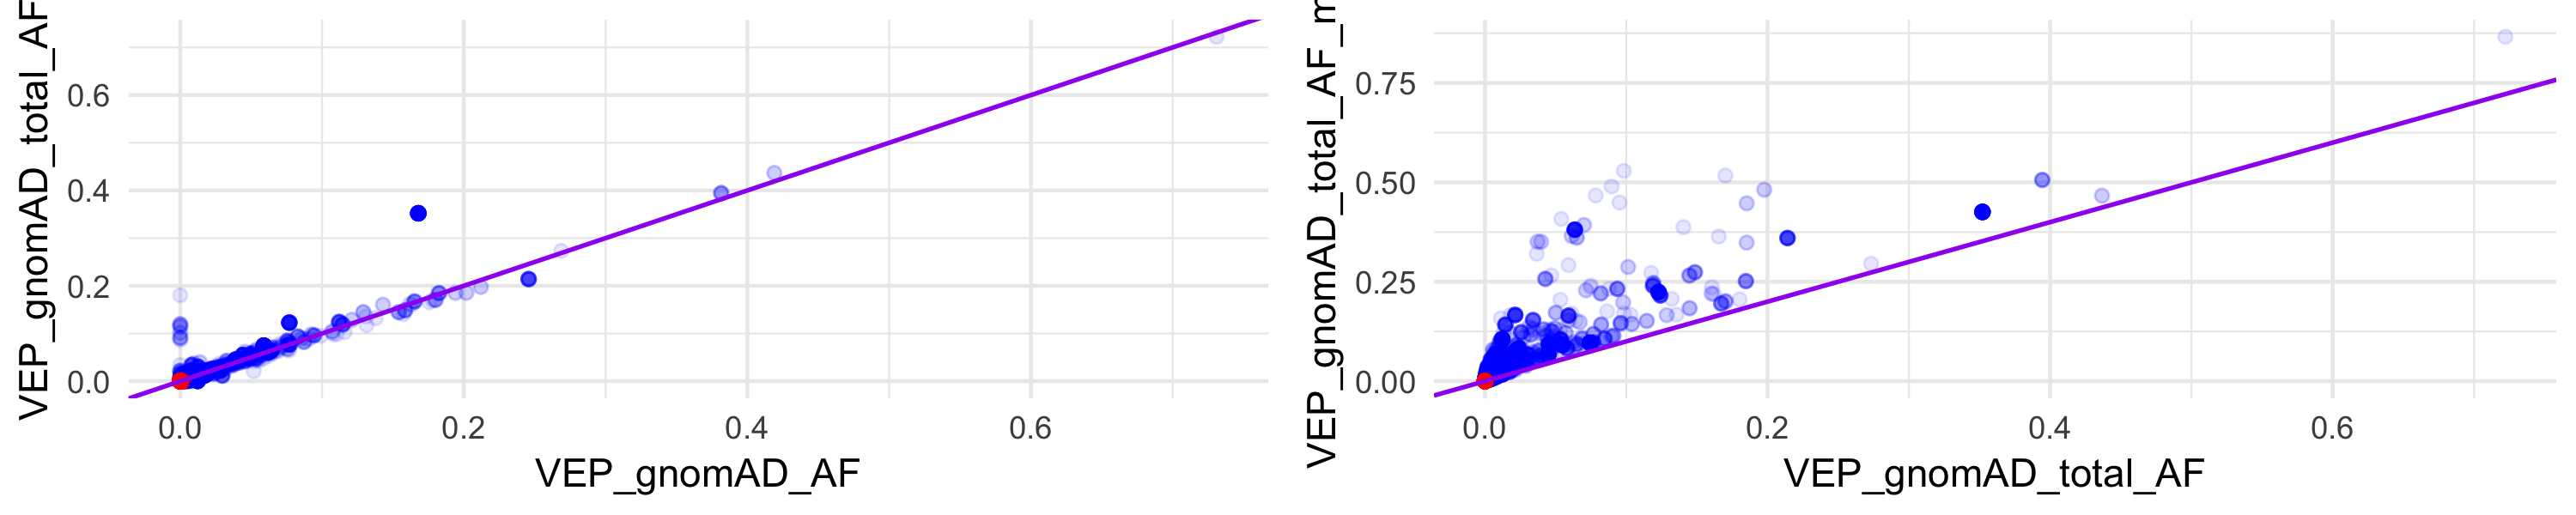

In [115]:
plot1 <- plot_density_2d(impact, "VEP_gnomAD_AF", "VEP_gnomAD_total_AF", points_only = TRUE, height = 2) + geom_abline(intercept = 0, slope = 1, color ="purple", size = 0.6)
plot2 <- plot_density_2d(impact, "VEP_gnomAD_total_AF", "VEP_gnomAD_total_AF_max", points_only = TRUE, height = 2) + geom_abline(intercept = 0, slope = 1, color ="purple", size = 0.6)
plot_side_by_side(plot1, plot2)

We remove the features we won't use, ie:
* `VEP_gnomAD_genome_AC.AN_<POP>`: 7 features
* `VEP_gnomAD_exome_AC.AN_<POP>`: 7 features
* `VEP_gnomAD_total_AC.AN_<POP>`: 7 features

In [116]:
# [-21 features] remove VEP_gnomAD_genome_AC.AN_<POP>, VEP_gnomAD_exome_AC.AN_<POP> and VEP_gnomAD_total_AC.AN_<POP>
impact[, colnames(impact)[grepl("VEP_gnomAD_genome_AC.AN", colnames(impact))]] <- NULL
impact[, colnames(impact)[grepl("VEP_gnomAD_exome_AC.AN", colnames(impact))]] <- NULL
impact[, colnames(impact)[grepl("VEP_gnomAD_total_AC.AN", colnames(impact))]] <- NULL

In [117]:
vep_gnomad_colnames <- c("VEP_gnomAD_AF",
                         "VEP_gnomAD_total_AF_AFR",
                         "VEP_gnomAD_total_AF_AMR",
                         "VEP_gnomAD_total_AF_ASJ",
                         "VEP_gnomAD_total_AF_EAS",
                         "VEP_gnomAD_total_AF_FIN",
                         "VEP_gnomAD_total_AF_NFE",
                         "VEP_gnomAD_total_AF_OTH",
                         "VEP_gnomAD_total_AF_max",
                         "VEP_gnomAD_total_AF")